In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist 
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

2025-04-24 19:13:58.835969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 19:13:58.836501: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 19:13:58.838882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 19:13:58.845655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745514838.855385 1425309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745514838.85

Primero vamos a ver ejemplos de las imágenes a generar

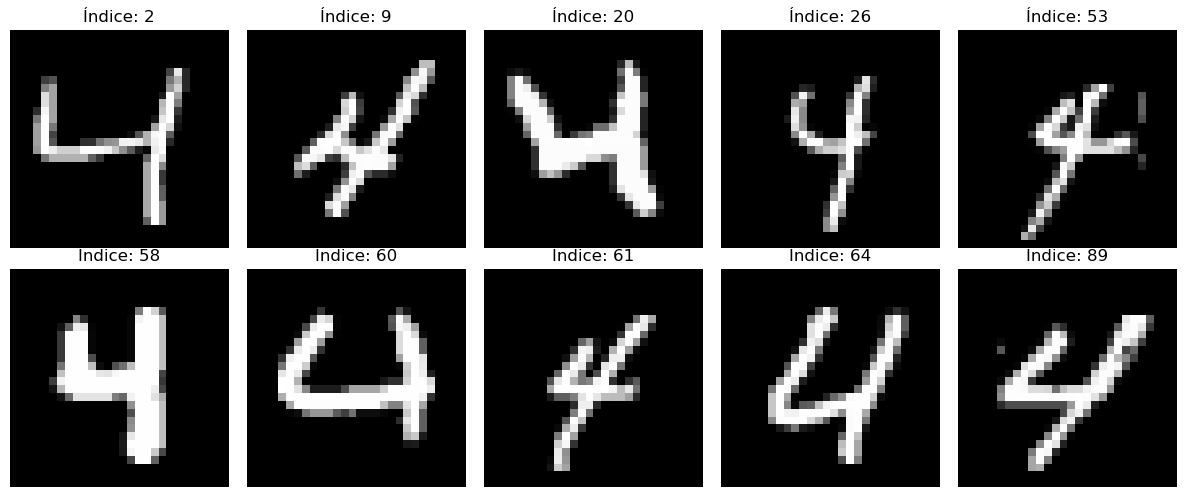

In [2]:
# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Filtrar los índices del número 4
cuatro_indices = np.where(y_train == 4)[0]

# Mostrar las primeras 10 imágenes del número 4
plt.figure(figsize=(12, 5))
for i in range(10):
    idx = cuatro_indices[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Índice: {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:
# Semillas para la reproducibilidad
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# Seleccionamos algunos parámetros para los modelos
TAM_ENTRADA = 100  # Tamaño de la entrada para el generador
TAM_LOTE = 64
ERROR = 'binary_crossentropy'  # Función de pérdida para los modelos
LEAKY_SLOPE = 0.2  # Slope para la activación LeakyReLU
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)  # Optimizador Adam para el discriminador
opt_gan = Adam(learning_rate=0.0002, beta_1=0.5)  # Optimizador Adam para la GAN y el generador

2025-04-24 19:14:00.595466: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# El modelo generador a partir de ruido aleatorio generará imágenes
# La capa de salida tanh genera una salida entre -1 y 1, por lo tanto las imágenes deberán tener este formato
# Las capas Conv2DTranspose hacen lo contrario que una capa Conv2D, en vez de encontrar características en una imagen van dibujando características en una imagen
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(7 * 7 * 128, use_bias=False, input_shape=(TAM_ENTRADA,))) # Se crea un vector con la entrada de ruido de tamaño 7x7x128
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((7, 7, 128))) # Se convierte el vector a tamaño (7,7,128)
    modelo.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)) # Se realiza un upsampling y nos quedamos con un vector de 14x14 de 128 canales
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False)) # Se vuelve al realizar un upsampling y nos quedamos con un vector de 28x28 de 64 canales
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Conv2DTranspose(1, kernel_size=7, strides=1, padding='same', use_bias=False, activation='tanh')) # Se reducen todos los canales a 1, quedando una imagen de 28x28
    return modelo

In [6]:
# El discriminador busca las características de una imagen y las clasifica
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1), use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Dropout(0.3))
    modelo.add(Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Dropout(0.3))
    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))
    modelo.compile(optimizer=opt_d, loss=ERROR)
    return modelo


In [7]:
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    # Congelamos el discriminador durante el entrenamiento del generador
    discriminador.trainable = False
    modelo.add(generador)
    modelo.add(discriminador)
    modelo.compile(optimizer=opt_gan, loss=ERROR)
    return modelo

In [8]:
# Función para cargar los datos del número 4 desde MNIST
def cargar_datos():
    print('Cargando dígitos "4" desde MNIST...', end="", flush=True)
    # Cargamos los datos de MNIST
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # Filtramos las imágenes del número 4
    cuatro_idx = np.where(y_train == 4)[0]
    x_cuatro = x_train[cuatro_idx]
    # Expandimos dimensiones para que tenga forma (28, 28, 1)
    x_cuatro = np.expand_dims(x_cuatro, axis=-1)
    # Normalizamos las imágenes entre [-1, 1]
    x_cuatro = (x_cuatro.astype(np.float32) - 127.5) / 127.5
    print('¡Listo!')
    return x_cuatro


In [9]:
# Función para ir mostrando los resultados durante el entrenamiento
def graficar_imagenes_generadas(epoch, generador, tam_lote=16):
    # Generamos un lote de ruido aleatorio para generar las imágenes
    ruido = np.random.normal(0, 1, (tam_lote, TAM_ENTRADA))
    # Generamos las imágenes a partir del ruido usando el generador
    imagenes_generadas = generador.predict(ruido)
    # Desnormalizamos las imágenes generadas para que estén en el rango [0, 1]
    imagenes_generadas = (imagenes_generadas + 1) / 2


    fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharex=True, sharey=True)
    axs = axs.ravel()
    for i in range(tam_lote):
        axs[i].imshow(imagenes_generadas[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Imágenes generadas - Epoch {epoch}')
    plt.tight_layout()
    plt.show()


Para entrena las **Redes Adversarias** debemos llevar a cabo estos pasos:

1. Entrenar el **Discriminador**  
2. “Congelar” los coeficientes del Discriminador  
3. Entrenar únicamente el **Generador**  
4. “Descongelar” los coeficientes del Discriminador  
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar en el entrenamiento

Usaremos trin_on_batch en vez de fit porque nos permite controlar qué pasa en cada iteración

In [10]:
# Función para realizar el entrenamiento
def entrenar_gan(N_ITS):
    # Carganos los datos y creamos los modelos
    x_train = cargar_datos()
    generador = crear_generador()
    discriminador = crear_discriminador()
    gan = crear_GAN(generador, discriminador)

    # Comienza el entrenamiento de N_ITS epocs
    for i in range(1, N_ITS + 1):
        print(f"Epoch {i}")

        # Generamos un lote de ruido aleatorio para generar imágenes con el generador
        ruido = np.random.normal(0, 1, (TAM_LOTE, TAM_ENTRADA))
        imagenes_falsas = generador.predict(ruido, verbose=0)

        # Seleccionamos imágenes reales del conjunto de datos
        idx = np.random.randint(0, x_train.shape[0], TAM_LOTE)
        imagenes_reales = x_train[idx]

        # Etiquetamos las imágenes reales (1) y falsas (0)
        reales = np.ones(TAM_LOTE) * 0.9
        falsas = np.zeros(TAM_LOTE)

        # Entrenamos el discriminador con imágenes reales y falsas
        # 4
        discriminador.trainable = True
        # 1
        d_loss_real = discriminador.train_on_batch(imagenes_reales, reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_falsas, falsas)

        # Entrenamos el generador
        # 2
        discriminador.trainable = False
        # 3
        g_loss = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

        # Mostramos las métricas para cada época
        print(f"  D_real: {d_loss_real:.4f}, D_fake: {d_loss_fake:.4f}, G: {g_loss:.4f}")

        # Vamos mostrando las imágenes generadas
        if i == 1 or i % 100 == 0:
            graficar_imagenes_generadas(i, generador)



In [11]:
# Establecer semillas para reproducibilidad
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

Cargando dígitos "4" desde MNIST...¡Listo!
Epoch 1


/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  D_real: 0.5695, D_fake: 0.6449, G: 0.6339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


2025-04-24 19:14:02.311128: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


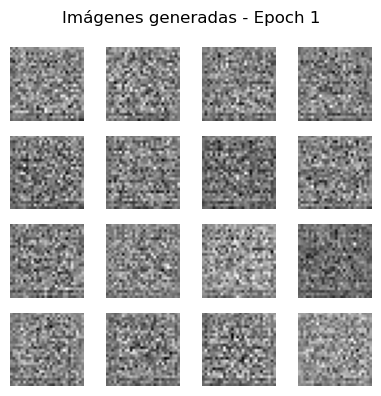

Epoch 2
  D_real: 0.5749, D_fake: 0.6625, G: 0.5206
Epoch 3
  D_real: 0.6058, D_fake: 0.6832, G: 0.4546
Epoch 4
  D_real: 0.6387, D_fake: 0.7078, G: 0.4396
Epoch 5
  D_real: 0.6708, D_fake: 0.7112, G: 0.4910
Epoch 6
  D_real: 0.6818, D_fake: 0.6925, G: 0.5257
Epoch 7
  D_real: 0.6741, D_fake: 0.6833, G: 0.5648
Epoch 8
  D_real: 0.6653, D_fake: 0.6746, G: 0.6051
Epoch 9
  D_real: 0.6582, D_fake: 0.6489, G: 0.6389
Epoch 10
  D_real: 0.6374, D_fake: 0.6287, G: 0.6942
Epoch 11
  D_real: 0.6185, D_fake: 0.6129, G: 0.7510
Epoch 12
  D_real: 0.6055, D_fake: 0.5931, G: 0.7853
Epoch 13
  D_real: 0.5856, D_fake: 0.5777, G: 0.8125
Epoch 14
  D_real: 0.5728, D_fake: 0.5639, G: 0.8460
Epoch 15
  D_real: 0.5584, D_fake: 0.5497, G: 0.8862
Epoch 16
  D_real: 0.5449, D_fake: 0.5373, G: 0.9274
Epoch 17
  D_real: 0.5341, D_fake: 0.5262, G: 0.9708
Epoch 18
  D_real: 0.5231, D_fake: 0.5165, G: 1.0004
Epoch 19
  D_real: 0.5137, D_fake: 0.5064, G: 1.0431
Epoch 20
  D_real: 0.5046, D_fake: 0.4982, G: 1.0728
E

2025-04-24 19:14:15.124491: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


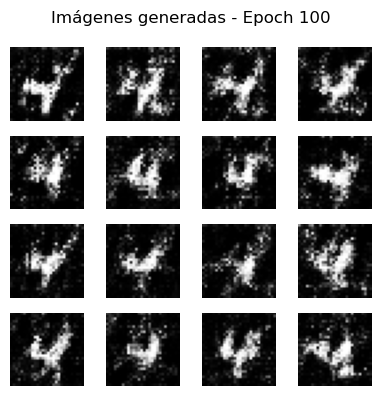

Epoch 101
  D_real: 0.5672, D_fake: 0.5682, G: 1.4521
Epoch 102
  D_real: 0.5706, D_fake: 0.5711, G: 1.4491
Epoch 103
  D_real: 0.5741, D_fake: 0.5744, G: 1.4472
Epoch 104
  D_real: 0.5759, D_fake: 0.5763, G: 1.4449
Epoch 105
  D_real: 0.5780, D_fake: 0.5777, G: 1.4439
Epoch 106
  D_real: 0.5794, D_fake: 0.5790, G: 1.4411
Epoch 107
  D_real: 0.5805, D_fake: 0.5813, G: 1.4379
Epoch 108
  D_real: 0.5824, D_fake: 0.5826, G: 1.4351
Epoch 109
  D_real: 0.5841, D_fake: 0.5847, G: 1.4328
Epoch 110
  D_real: 0.5863, D_fake: 0.5861, G: 1.4315
Epoch 111
  D_real: 0.5875, D_fake: 0.5882, G: 1.4295
Epoch 112
  D_real: 0.5899, D_fake: 0.5896, G: 1.4289
Epoch 113
  D_real: 0.5913, D_fake: 0.5909, G: 1.4292
Epoch 114
  D_real: 0.5922, D_fake: 0.5915, G: 1.4287
Epoch 115
  D_real: 0.5925, D_fake: 0.5926, G: 1.4265
Epoch 116
  D_real: 0.5937, D_fake: 0.5933, G: 1.4246
Epoch 117
  D_real: 0.5941, D_fake: 0.5947, G: 1.4215
Epoch 118
  D_real: 0.5957, D_fake: 0.5956, G: 1.4184
Epoch 119
  D_real: 0.5974, 

2025-04-24 19:14:27.997044: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


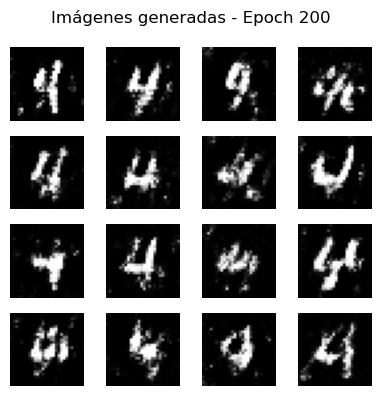

Epoch 201
  D_real: 0.6712, D_fake: 0.6712, G: 1.2837
Epoch 202
  D_real: 0.6718, D_fake: 0.6720, G: 1.2823
Epoch 203
  D_real: 0.6725, D_fake: 0.6725, G: 1.2811
Epoch 204
  D_real: 0.6731, D_fake: 0.6731, G: 1.2797
Epoch 205
  D_real: 0.6735, D_fake: 0.6734, G: 1.2784
Epoch 206
  D_real: 0.6740, D_fake: 0.6739, G: 1.2778
Epoch 207
  D_real: 0.6740, D_fake: 0.6738, G: 1.2769
Epoch 208
  D_real: 0.6743, D_fake: 0.6741, G: 1.2760
Epoch 209
  D_real: 0.6746, D_fake: 0.6746, G: 1.2750
Epoch 210
  D_real: 0.6751, D_fake: 0.6749, G: 1.2742
Epoch 211
  D_real: 0.6757, D_fake: 0.6757, G: 1.2724
Epoch 212
  D_real: 0.6760, D_fake: 0.6761, G: 1.2707
Epoch 213
  D_real: 0.6764, D_fake: 0.6765, G: 1.2693
Epoch 214
  D_real: 0.6773, D_fake: 0.6778, G: 1.2682
Epoch 215
  D_real: 0.6785, D_fake: 0.6781, G: 1.2671
Epoch 216
  D_real: 0.6787, D_fake: 0.6788, G: 1.2658
Epoch 217
  D_real: 0.6793, D_fake: 0.6793, G: 1.2650
Epoch 218
  D_real: 0.6797, D_fake: 0.6796, G: 1.2641
Epoch 219
  D_real: 0.6801, 

2025-04-24 19:14:41.010144: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


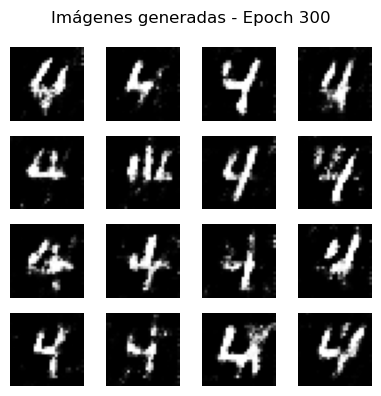

Epoch 301
  D_real: 0.7067, D_fake: 0.7065, G: 1.1957
Epoch 302
  D_real: 0.7067, D_fake: 0.7066, G: 1.1949
Epoch 303
  D_real: 0.7067, D_fake: 0.7066, G: 1.1940
Epoch 304
  D_real: 0.7069, D_fake: 0.7070, G: 1.1930
Epoch 305
  D_real: 0.7073, D_fake: 0.7072, G: 1.1923
Epoch 306
  D_real: 0.7075, D_fake: 0.7075, G: 1.1918
Epoch 307
  D_real: 0.7077, D_fake: 0.7077, G: 1.1912
Epoch 308
  D_real: 0.7080, D_fake: 0.7081, G: 1.1908
Epoch 309
  D_real: 0.7083, D_fake: 0.7082, G: 1.1902
Epoch 310
  D_real: 0.7085, D_fake: 0.7084, G: 1.1896
Epoch 311
  D_real: 0.7086, D_fake: 0.7088, G: 1.1888
Epoch 312
  D_real: 0.7090, D_fake: 0.7091, G: 1.1884
Epoch 313
  D_real: 0.7094, D_fake: 0.7092, G: 1.1877
Epoch 314
  D_real: 0.7094, D_fake: 0.7092, G: 1.1874
Epoch 315
  D_real: 0.7096, D_fake: 0.7095, G: 1.1873
Epoch 316
  D_real: 0.7095, D_fake: 0.7094, G: 1.1867
Epoch 317
  D_real: 0.7097, D_fake: 0.7095, G: 1.1863
Epoch 318
  D_real: 0.7098, D_fake: 0.7096, G: 1.1858
Epoch 319
  D_real: 0.7099, 

2025-04-24 19:14:53.709317: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


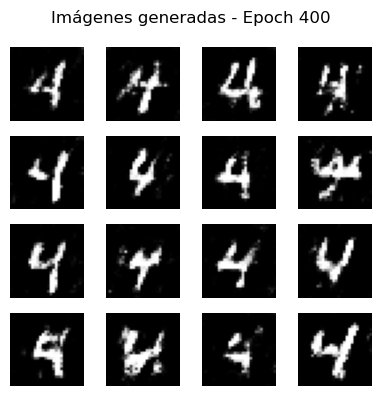

Epoch 401
  D_real: 0.7198, D_fake: 0.7197, G: 1.1491
Epoch 402
  D_real: 0.7199, D_fake: 0.7197, G: 1.1489
Epoch 403
  D_real: 0.7199, D_fake: 0.7197, G: 1.1487
Epoch 404
  D_real: 0.7199, D_fake: 0.7197, G: 1.1481
Epoch 405
  D_real: 0.7198, D_fake: 0.7199, G: 1.1477
Epoch 406
  D_real: 0.7200, D_fake: 0.7202, G: 1.1472
Epoch 407
  D_real: 0.7203, D_fake: 0.7202, G: 1.1469
Epoch 408
  D_real: 0.7202, D_fake: 0.7201, G: 1.1469
Epoch 409
  D_real: 0.7203, D_fake: 0.7201, G: 1.1465
Epoch 410
  D_real: 0.7203, D_fake: 0.7201, G: 1.1463
Epoch 411
  D_real: 0.7203, D_fake: 0.7202, G: 1.1461
Epoch 412
  D_real: 0.7203, D_fake: 0.7202, G: 1.1458
Epoch 413
  D_real: 0.7203, D_fake: 0.7202, G: 1.1453
Epoch 414
  D_real: 0.7204, D_fake: 0.7203, G: 1.1451
Epoch 415
  D_real: 0.7206, D_fake: 0.7204, G: 1.1448
Epoch 416
  D_real: 0.7207, D_fake: 0.7206, G: 1.1447
Epoch 417
  D_real: 0.7208, D_fake: 0.7207, G: 1.1445
Epoch 418
  D_real: 0.7208, D_fake: 0.7207, G: 1.1443
Epoch 419
  D_real: 0.7207, 

2025-04-24 19:15:06.204164: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


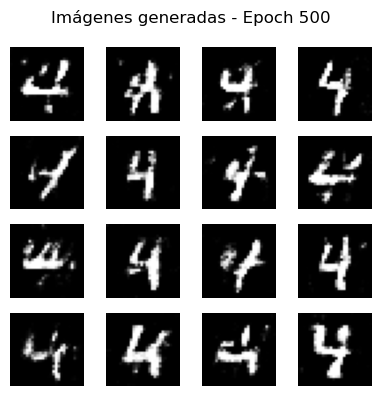

Epoch 501
  D_real: 0.7245, D_fake: 0.7244, G: 1.1199
Epoch 502
  D_real: 0.7244, D_fake: 0.7242, G: 1.1199
Epoch 503
  D_real: 0.7243, D_fake: 0.7241, G: 1.1197
Epoch 504
  D_real: 0.7242, D_fake: 0.7241, G: 1.1194
Epoch 505
  D_real: 0.7242, D_fake: 0.7240, G: 1.1191
Epoch 506
  D_real: 0.7241, D_fake: 0.7241, G: 1.1189
Epoch 507
  D_real: 0.7242, D_fake: 0.7241, G: 1.1185
Epoch 508
  D_real: 0.7241, D_fake: 0.7241, G: 1.1182
Epoch 509
  D_real: 0.7242, D_fake: 0.7241, G: 1.1177
Epoch 510
  D_real: 0.7243, D_fake: 0.7243, G: 1.1174
Epoch 511
  D_real: 0.7244, D_fake: 0.7243, G: 1.1171
Epoch 512
  D_real: 0.7244, D_fake: 0.7243, G: 1.1170
Epoch 513
  D_real: 0.7244, D_fake: 0.7243, G: 1.1167
Epoch 514
  D_real: 0.7244, D_fake: 0.7243, G: 1.1165
Epoch 515
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 516
  D_real: 0.7244, D_fake: 0.7242, G: 1.1165
Epoch 517
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 518
  D_real: 0.7243, D_fake: 0.7241, G: 1.1165
Epoch 519
  D_real: 0.7241, 

2025-04-24 19:15:18.650437: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


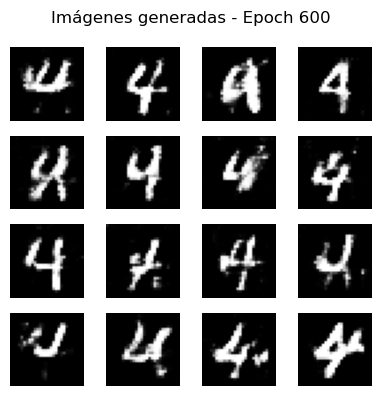

Epoch 601
  D_real: 0.7252, D_fake: 0.7251, G: 1.1007
Epoch 602
  D_real: 0.7252, D_fake: 0.7250, G: 1.1005
Epoch 603
  D_real: 0.7252, D_fake: 0.7251, G: 1.1004
Epoch 604
  D_real: 0.7252, D_fake: 0.7251, G: 1.1003
Epoch 605
  D_real: 0.7252, D_fake: 0.7250, G: 1.1001
Epoch 606
  D_real: 0.7251, D_fake: 0.7250, G: 1.1000
Epoch 607
  D_real: 0.7251, D_fake: 0.7249, G: 1.1001
Epoch 608
  D_real: 0.7250, D_fake: 0.7249, G: 1.0999
Epoch 609
  D_real: 0.7250, D_fake: 0.7249, G: 1.0998
Epoch 610
  D_real: 0.7249, D_fake: 0.7249, G: 1.0998
Epoch 611
  D_real: 0.7248, D_fake: 0.7248, G: 1.0997
Epoch 612
  D_real: 0.7249, D_fake: 0.7248, G: 1.0997
Epoch 613
  D_real: 0.7249, D_fake: 0.7248, G: 1.0998
Epoch 614
  D_real: 0.7248, D_fake: 0.7248, G: 1.0995
Epoch 615
  D_real: 0.7248, D_fake: 0.7247, G: 1.0991
Epoch 616
  D_real: 0.7248, D_fake: 0.7248, G: 1.0989
Epoch 617
  D_real: 0.7249, D_fake: 0.7248, G: 1.0988
Epoch 618
  D_real: 0.7249, D_fake: 0.7249, G: 1.0986
Epoch 619
  D_real: 0.7251, 

2025-04-24 19:15:31.356497: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


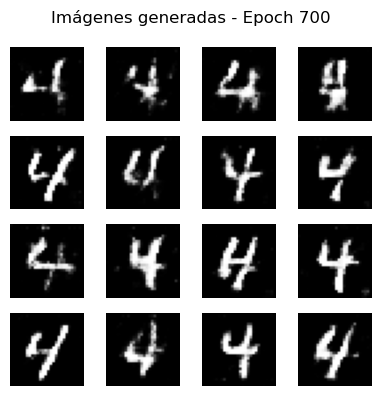

Epoch 701
  D_real: 0.7248, D_fake: 0.7246, G: 1.0880
Epoch 702
  D_real: 0.7247, D_fake: 0.7245, G: 1.0880
Epoch 703
  D_real: 0.7245, D_fake: 0.7243, G: 1.0879
Epoch 704
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 705
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 706
  D_real: 0.7244, D_fake: 0.7242, G: 1.0877
Epoch 707
  D_real: 0.7242, D_fake: 0.7242, G: 1.0876
Epoch 708
  D_real: 0.7243, D_fake: 0.7242, G: 1.0874
Epoch 709
  D_real: 0.7243, D_fake: 0.7242, G: 1.0872
Epoch 710
  D_real: 0.7243, D_fake: 0.7242, G: 1.0871
Epoch 711
  D_real: 0.7242, D_fake: 0.7242, G: 1.0869
Epoch 712
  D_real: 0.7243, D_fake: 0.7242, G: 1.0866
Epoch 713
  D_real: 0.7242, D_fake: 0.7241, G: 1.0865
Epoch 714
  D_real: 0.7242, D_fake: 0.7242, G: 1.0866
Epoch 715
  D_real: 0.7244, D_fake: 0.7242, G: 1.0867
Epoch 716
  D_real: 0.7243, D_fake: 0.7242, G: 1.0868
Epoch 717
  D_real: 0.7242, D_fake: 0.7241, G: 1.0869
Epoch 718
  D_real: 0.7241, D_fake: 0.7240, G: 1.0869
Epoch 719
  D_real: 0.7240, 

2025-04-24 19:15:44.388148: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


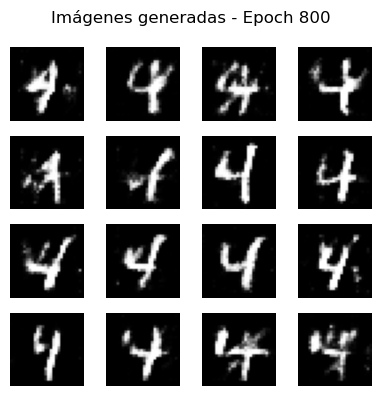

Epoch 801
  D_real: 0.7230, D_fake: 0.7230, G: 1.0794
Epoch 802
  D_real: 0.7231, D_fake: 0.7230, G: 1.0793
Epoch 803
  D_real: 0.7230, D_fake: 0.7230, G: 1.0792
Epoch 804
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 805
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 806
  D_real: 0.7229, D_fake: 0.7228, G: 1.0792
Epoch 807
  D_real: 0.7229, D_fake: 0.7227, G: 1.0791
Epoch 808
  D_real: 0.7228, D_fake: 0.7227, G: 1.0790
Epoch 809
  D_real: 0.7226, D_fake: 0.7226, G: 1.0788
Epoch 810
  D_real: 0.7227, D_fake: 0.7226, G: 1.0788
Epoch 811
  D_real: 0.7227, D_fake: 0.7226, G: 1.0787
Epoch 812
  D_real: 0.7226, D_fake: 0.7226, G: 1.0787
Epoch 813
  D_real: 0.7227, D_fake: 0.7227, G: 1.0786
Epoch 814
  D_real: 0.7228, D_fake: 0.7227, G: 1.0785
Epoch 815
  D_real: 0.7228, D_fake: 0.7226, G: 1.0785
Epoch 816
  D_real: 0.7226, D_fake: 0.7225, G: 1.0784
Epoch 817
  D_real: 0.7226, D_fake: 0.7225, G: 1.0783
Epoch 818
  D_real: 0.7224, D_fake: 0.7224, G: 1.0783
Epoch 819
  D_real: 0.7224, 

2025-04-24 19:15:57.020511: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


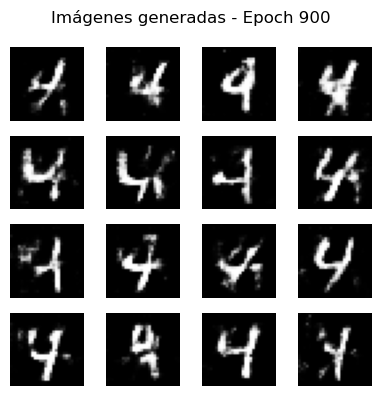

Epoch 901
  D_real: 0.7212, D_fake: 0.7211, G: 1.0732
Epoch 902
  D_real: 0.7211, D_fake: 0.7209, G: 1.0733
Epoch 903
  D_real: 0.7209, D_fake: 0.7208, G: 1.0732
Epoch 904
  D_real: 0.7208, D_fake: 0.7208, G: 1.0731
Epoch 905
  D_real: 0.7208, D_fake: 0.7208, G: 1.0730
Epoch 906
  D_real: 0.7208, D_fake: 0.7208, G: 1.0729
Epoch 907
  D_real: 0.7209, D_fake: 0.7209, G: 1.0727
Epoch 908
  D_real: 0.7209, D_fake: 0.7209, G: 1.0725
Epoch 909
  D_real: 0.7210, D_fake: 0.7209, G: 1.0723
Epoch 910
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 911
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 912
  D_real: 0.7211, D_fake: 0.7209, G: 1.0723
Epoch 913
  D_real: 0.7210, D_fake: 0.7208, G: 1.0721
Epoch 914
  D_real: 0.7209, D_fake: 0.7208, G: 1.0720
Epoch 915
  D_real: 0.7208, D_fake: 0.7209, G: 1.0720
Epoch 916
  D_real: 0.7210, D_fake: 0.7211, G: 1.0719
Epoch 917
  D_real: 0.7212, D_fake: 0.7211, G: 1.0718
Epoch 918
  D_real: 0.7213, D_fake: 0.7212, G: 1.0718
Epoch 919
  D_real: 0.7212, 

2025-04-24 19:16:09.667218: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


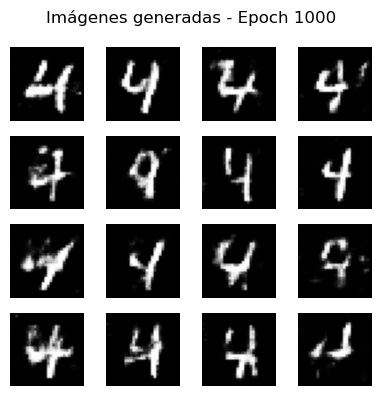

Epoch 1001
  D_real: 0.7195, D_fake: 0.7194, G: 1.0680
Epoch 1002
  D_real: 0.7194, D_fake: 0.7193, G: 1.0680
Epoch 1003
  D_real: 0.7193, D_fake: 0.7192, G: 1.0679
Epoch 1004
  D_real: 0.7192, D_fake: 0.7192, G: 1.0677
Epoch 1005
  D_real: 0.7192, D_fake: 0.7193, G: 1.0675
Epoch 1006
  D_real: 0.7194, D_fake: 0.7195, G: 1.0674
Epoch 1007
  D_real: 0.7195, D_fake: 0.7195, G: 1.0673
Epoch 1008
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1009
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1010
  D_real: 0.7195, D_fake: 0.7195, G: 1.0671
Epoch 1011
  D_real: 0.7195, D_fake: 0.7193, G: 1.0673
Epoch 1012
  D_real: 0.7193, D_fake: 0.7191, G: 1.0676
Epoch 1013
  D_real: 0.7192, D_fake: 0.7190, G: 1.0677
Epoch 1014
  D_real: 0.7189, D_fake: 0.7188, G: 1.0678
Epoch 1015
  D_real: 0.7188, D_fake: 0.7187, G: 1.0677
Epoch 1016
  D_real: 0.7187, D_fake: 0.7186, G: 1.0677
Epoch 1017
  D_real: 0.7187, D_fake: 0.7187, G: 1.0675
Epoch 1018
  D_real: 0.7187, D_fake: 0.7187, G: 1.0674
Epoch 1019

2025-04-24 19:16:22.979228: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


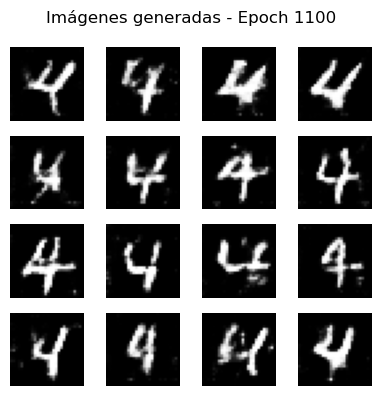

Epoch 1101
  D_real: 0.7166, D_fake: 0.7166, G: 1.0646
Epoch 1102
  D_real: 0.7166, D_fake: 0.7166, G: 1.0644
Epoch 1103
  D_real: 0.7166, D_fake: 0.7166, G: 1.0643
Epoch 1104
  D_real: 0.7167, D_fake: 0.7166, G: 1.0643
Epoch 1105
  D_real: 0.7166, D_fake: 0.7165, G: 1.0643
Epoch 1106
  D_real: 0.7165, D_fake: 0.7164, G: 1.0642
Epoch 1107
  D_real: 0.7164, D_fake: 0.7164, G: 1.0641
Epoch 1108
  D_real: 0.7164, D_fake: 0.7163, G: 1.0641
Epoch 1109
  D_real: 0.7164, D_fake: 0.7162, G: 1.0641
Epoch 1110
  D_real: 0.7162, D_fake: 0.7162, G: 1.0641
Epoch 1111
  D_real: 0.7162, D_fake: 0.7161, G: 1.0641
Epoch 1112
  D_real: 0.7161, D_fake: 0.7161, G: 1.0640
Epoch 1113
  D_real: 0.7161, D_fake: 0.7160, G: 1.0639
Epoch 1114
  D_real: 0.7161, D_fake: 0.7160, G: 1.0638
Epoch 1115
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1116
  D_real: 0.7160, D_fake: 0.7159, G: 1.0638
Epoch 1117
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1118
  D_real: 0.7159, D_fake: 0.7158, G: 1.0639
Epoch 1119

2025-04-24 19:16:36.398817: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


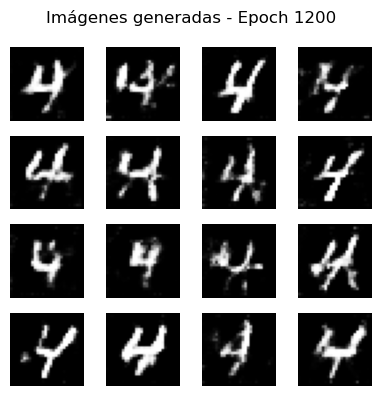

Epoch 1201
  D_real: 0.7149, D_fake: 0.7148, G: 1.0595
Epoch 1202
  D_real: 0.7149, D_fake: 0.7148, G: 1.0596
Epoch 1203
  D_real: 0.7148, D_fake: 0.7146, G: 1.0597
Epoch 1204
  D_real: 0.7147, D_fake: 0.7145, G: 1.0599
Epoch 1205
  D_real: 0.7145, D_fake: 0.7145, G: 1.0598
Epoch 1206
  D_real: 0.7145, D_fake: 0.7145, G: 1.0597
Epoch 1207
  D_real: 0.7145, D_fake: 0.7146, G: 1.0595
Epoch 1208
  D_real: 0.7146, D_fake: 0.7147, G: 1.0594
Epoch 1209
  D_real: 0.7147, D_fake: 0.7147, G: 1.0593
Epoch 1210
  D_real: 0.7148, D_fake: 0.7147, G: 1.0593
Epoch 1211
  D_real: 0.7147, D_fake: 0.7146, G: 1.0593
Epoch 1212
  D_real: 0.7147, D_fake: 0.7146, G: 1.0594
Epoch 1213
  D_real: 0.7146, D_fake: 0.7145, G: 1.0595
Epoch 1214
  D_real: 0.7146, D_fake: 0.7144, G: 1.0597
Epoch 1215
  D_real: 0.7144, D_fake: 0.7143, G: 1.0596
Epoch 1216
  D_real: 0.7143, D_fake: 0.7143, G: 1.0595
Epoch 1217
  D_real: 0.7143, D_fake: 0.7142, G: 1.0594
Epoch 1218
  D_real: 0.7142, D_fake: 0.7141, G: 1.0593
Epoch 1219

2025-04-24 19:16:49.639577: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


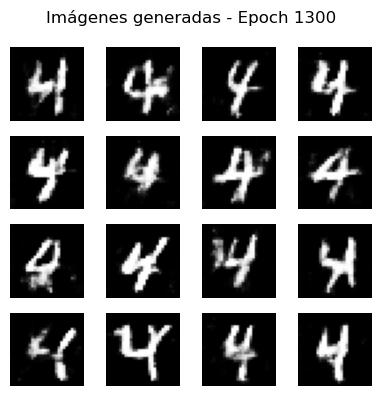

Epoch 1301
  D_real: 0.7116, D_fake: 0.7116, G: 1.0563
Epoch 1302
  D_real: 0.7117, D_fake: 0.7117, G: 1.0562
Epoch 1303
  D_real: 0.7118, D_fake: 0.7119, G: 1.0560
Epoch 1304
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1305
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1306
  D_real: 0.7120, D_fake: 0.7119, G: 1.0560
Epoch 1307
  D_real: 0.7119, D_fake: 0.7120, G: 1.0559
Epoch 1308
  D_real: 0.7120, D_fake: 0.7119, G: 1.0558
Epoch 1309
  D_real: 0.7120, D_fake: 0.7119, G: 1.0559
Epoch 1310
  D_real: 0.7119, D_fake: 0.7118, G: 1.0559
Epoch 1311
  D_real: 0.7118, D_fake: 0.7117, G: 1.0559
Epoch 1312
  D_real: 0.7117, D_fake: 0.7116, G: 1.0559
Epoch 1313
  D_real: 0.7116, D_fake: 0.7116, G: 1.0558
Epoch 1314
  D_real: 0.7116, D_fake: 0.7115, G: 1.0559
Epoch 1315
  D_real: 0.7115, D_fake: 0.7114, G: 1.0560
Epoch 1316
  D_real: 0.7114, D_fake: 0.7113, G: 1.0560
Epoch 1317
  D_real: 0.7113, D_fake: 0.7113, G: 1.0559
Epoch 1318
  D_real: 0.7113, D_fake: 0.7114, G: 1.0557
Epoch 1319

2025-04-24 19:17:02.841084: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


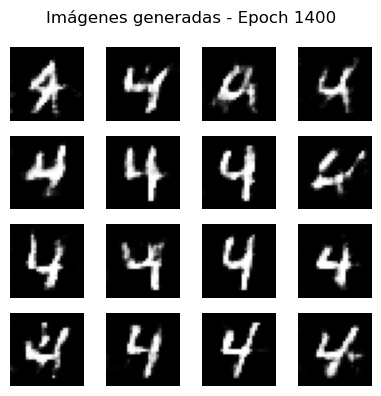

Epoch 1401
  D_real: 0.7100, D_fake: 0.7099, G: 1.0538
Epoch 1402
  D_real: 0.7099, D_fake: 0.7098, G: 1.0538
Epoch 1403
  D_real: 0.7098, D_fake: 0.7097, G: 1.0537
Epoch 1404
  D_real: 0.7097, D_fake: 0.7097, G: 1.0536
Epoch 1405
  D_real: 0.7097, D_fake: 0.7097, G: 1.0535
Epoch 1406
  D_real: 0.7097, D_fake: 0.7097, G: 1.0533
Epoch 1407
  D_real: 0.7098, D_fake: 0.7099, G: 1.0531
Epoch 1408
  D_real: 0.7100, D_fake: 0.7100, G: 1.0531
Epoch 1409
  D_real: 0.7100, D_fake: 0.7101, G: 1.0530
Epoch 1410
  D_real: 0.7102, D_fake: 0.7101, G: 1.0530
Epoch 1411
  D_real: 0.7102, D_fake: 0.7100, G: 1.0533
Epoch 1412
  D_real: 0.7100, D_fake: 0.7099, G: 1.0534
Epoch 1413
  D_real: 0.7099, D_fake: 0.7097, G: 1.0537
Epoch 1414
  D_real: 0.7096, D_fake: 0.7095, G: 1.0538
Epoch 1415
  D_real: 0.7095, D_fake: 0.7094, G: 1.0539
Epoch 1416
  D_real: 0.7093, D_fake: 0.7094, G: 1.0537
Epoch 1417
  D_real: 0.7094, D_fake: 0.7095, G: 1.0534
Epoch 1418
  D_real: 0.7095, D_fake: 0.7095, G: 1.0532
Epoch 1419

2025-04-24 19:17:16.510580: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


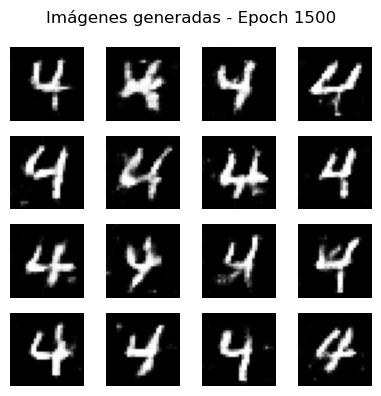

Epoch 1501
  D_real: 0.7068, D_fake: 0.7067, G: 1.0529
Epoch 1502
  D_real: 0.7067, D_fake: 0.7067, G: 1.0528
Epoch 1503
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1504
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1505
  D_real: 0.7067, D_fake: 0.7067, G: 1.0526
Epoch 1506
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1507
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1508
  D_real: 0.7066, D_fake: 0.7066, G: 1.0527
Epoch 1509
  D_real: 0.7066, D_fake: 0.7065, G: 1.0527
Epoch 1510
  D_real: 0.7065, D_fake: 0.7064, G: 1.0527
Epoch 1511
  D_real: 0.7064, D_fake: 0.7064, G: 1.0526
Epoch 1512
  D_real: 0.7063, D_fake: 0.7063, G: 1.0525
Epoch 1513
  D_real: 0.7064, D_fake: 0.7064, G: 1.0524
Epoch 1514
  D_real: 0.7064, D_fake: 0.7064, G: 1.0523
Epoch 1515
  D_real: 0.7065, D_fake: 0.7065, G: 1.0522
Epoch 1516
  D_real: 0.7065, D_fake: 0.7064, G: 1.0522
Epoch 1517
  D_real: 0.7065, D_fake: 0.7064, G: 1.0523
Epoch 1518
  D_real: 0.7064, D_fake: 0.7063, G: 1.0524
Epoch 1519

2025-04-24 19:17:29.735782: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


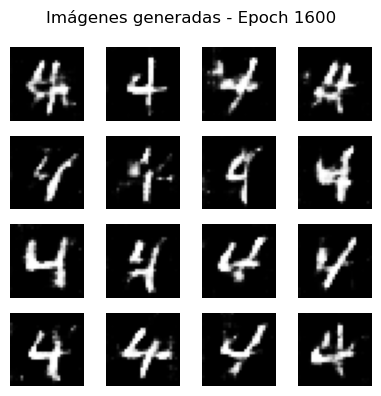

Epoch 1601
  D_real: 0.7031, D_fake: 0.7030, G: 1.0530
Epoch 1602
  D_real: 0.7030, D_fake: 0.7028, G: 1.0532
Epoch 1603
  D_real: 0.7028, D_fake: 0.7026, G: 1.0535
Epoch 1604
  D_real: 0.7026, D_fake: 0.7024, G: 1.0537
Epoch 1605
  D_real: 0.7024, D_fake: 0.7024, G: 1.0537
Epoch 1606
  D_real: 0.7023, D_fake: 0.7023, G: 1.0536
Epoch 1607
  D_real: 0.7023, D_fake: 0.7023, G: 1.0535
Epoch 1608
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1609
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1610
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1611
  D_real: 0.7022, D_fake: 0.7021, G: 1.0535
Epoch 1612
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1613
  D_real: 0.7022, D_fake: 0.7021, G: 1.0533
Epoch 1614
  D_real: 0.7022, D_fake: 0.7022, G: 1.0532
Epoch 1615
  D_real: 0.7022, D_fake: 0.7022, G: 1.0531
Epoch 1616
  D_real: 0.7022, D_fake: 0.7021, G: 1.0532
Epoch 1617
  D_real: 0.7021, D_fake: 0.7021, G: 1.0533
Epoch 1618
  D_real: 0.7021, D_fake: 0.7021, G: 1.0534
Epoch 1619

2025-04-24 19:17:42.340396: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


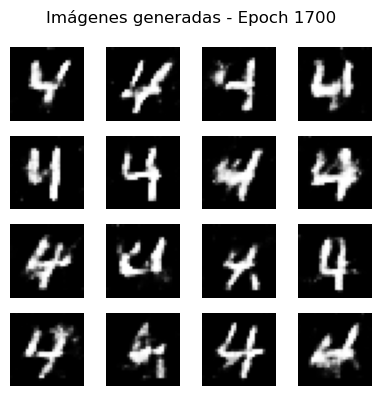

Epoch 1701
  D_real: 0.7003, D_fake: 0.7003, G: 1.0522
Epoch 1702
  D_real: 0.7003, D_fake: 0.7002, G: 1.0522
Epoch 1703
  D_real: 0.7002, D_fake: 0.7001, G: 1.0524
Epoch 1704
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1705
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1706
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1707
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1708
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1709
  D_real: 0.7001, D_fake: 0.7000, G: 1.0523
Epoch 1710
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1711
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1712
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1713
  D_real: 0.7001, D_fake: 0.7000, G: 1.0521
Epoch 1714
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1715
  D_real: 0.7001, D_fake: 0.7000, G: 1.0520
Epoch 1716
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1717
  D_real: 0.7000, D_fake: 0.6999, G: 1.0521
Epoch 1718
  D_real: 0.6999, D_fake: 0.6999, G: 1.0521
Epoch 1719

2025-04-24 19:17:55.194136: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


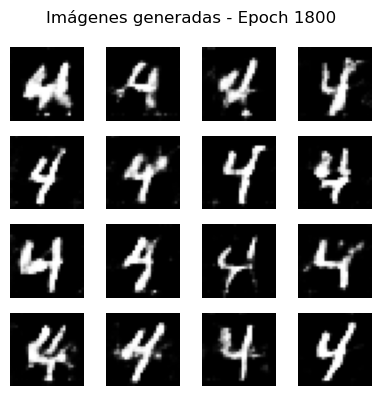

Epoch 1801
  D_real: 0.6981, D_fake: 0.6981, G: 1.0508
Epoch 1802
  D_real: 0.6981, D_fake: 0.6982, G: 1.0506
Epoch 1803
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1804
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1805
  D_real: 0.6983, D_fake: 0.6982, G: 1.0507
Epoch 1806
  D_real: 0.6982, D_fake: 0.6981, G: 1.0509
Epoch 1807
  D_real: 0.6981, D_fake: 0.6979, G: 1.0513
Epoch 1808
  D_real: 0.6979, D_fake: 0.6978, G: 1.0514
Epoch 1809
  D_real: 0.6978, D_fake: 0.6977, G: 1.0515
Epoch 1810
  D_real: 0.6977, D_fake: 0.6977, G: 1.0514
Epoch 1811
  D_real: 0.6976, D_fake: 0.6977, G: 1.0513
Epoch 1812
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1813
  D_real: 0.6977, D_fake: 0.6976, G: 1.0514
Epoch 1814
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1815
  D_real: 0.6976, D_fake: 0.6975, G: 1.0514
Epoch 1816
  D_real: 0.6975, D_fake: 0.6974, G: 1.0515
Epoch 1817
  D_real: 0.6974, D_fake: 0.6973, G: 1.0515
Epoch 1818
  D_real: 0.6973, D_fake: 0.6973, G: 1.0514
Epoch 1819

2025-04-24 19:18:08.423618: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


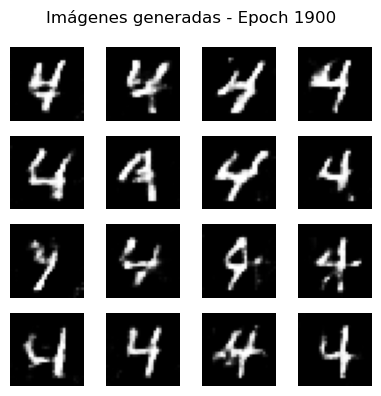

Epoch 1901
  D_real: 0.6953, D_fake: 0.6952, G: 1.0511
Epoch 1902
  D_real: 0.6952, D_fake: 0.6951, G: 1.0512
Epoch 1903
  D_real: 0.6950, D_fake: 0.6950, G: 1.0511
Epoch 1904
  D_real: 0.6949, D_fake: 0.6949, G: 1.0510
Epoch 1905
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1906
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1907
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1908
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1909
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1910
  D_real: 0.6950, D_fake: 0.6949, G: 1.0509
Epoch 1911
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1912
  D_real: 0.6949, D_fake: 0.6948, G: 1.0509
Epoch 1913
  D_real: 0.6948, D_fake: 0.6949, G: 1.0508
Epoch 1914
  D_real: 0.6949, D_fake: 0.6950, G: 1.0507
Epoch 1915
  D_real: 0.6950, D_fake: 0.6951, G: 1.0505
Epoch 1916
  D_real: 0.6952, D_fake: 0.6952, G: 1.0504
Epoch 1917
  D_real: 0.6953, D_fake: 0.6952, G: 1.0505
Epoch 1918
  D_real: 0.6953, D_fake: 0.6953, G: 1.0505
Epoch 1919

2025-04-24 19:18:20.998487: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


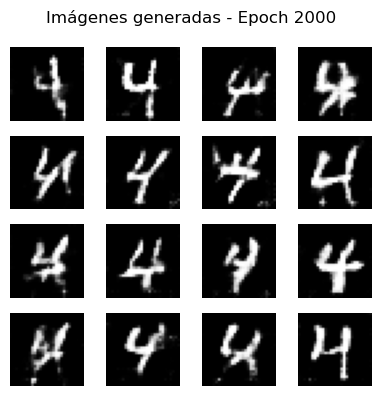

Epoch 2001
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2002
  D_real: 0.6929, D_fake: 0.6929, G: 1.0507
Epoch 2003
  D_real: 0.6930, D_fake: 0.6930, G: 1.0506
Epoch 2004
  D_real: 0.6931, D_fake: 0.6931, G: 1.0507
Epoch 2005
  D_real: 0.6931, D_fake: 0.6930, G: 1.0508
Epoch 2006
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2007
  D_real: 0.6930, D_fake: 0.6929, G: 1.0510
Epoch 2008
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2009
  D_real: 0.6928, D_fake: 0.6928, G: 1.0510
Epoch 2010
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2011
  D_real: 0.6928, D_fake: 0.6928, G: 1.0509
Epoch 2012
  D_real: 0.6928, D_fake: 0.6928, G: 1.0508
Epoch 2013
  D_real: 0.6928, D_fake: 0.6929, G: 1.0506
Epoch 2014
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2015
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2016
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2017
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2018
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2019

2025-04-24 19:18:33.383678: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


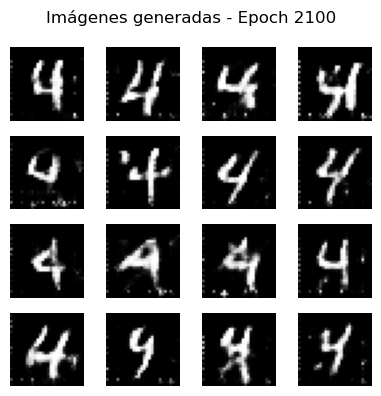

Epoch 2101
  D_real: 0.6873, D_fake: 0.6872, G: 1.0564
Epoch 2102
  D_real: 0.6872, D_fake: 0.6871, G: 1.0564
Epoch 2103
  D_real: 0.6871, D_fake: 0.6870, G: 1.0564
Epoch 2104
  D_real: 0.6870, D_fake: 0.6869, G: 1.0564
Epoch 2105
  D_real: 0.6869, D_fake: 0.6868, G: 1.0565
Epoch 2106
  D_real: 0.6868, D_fake: 0.6867, G: 1.0565
Epoch 2107
  D_real: 0.6867, D_fake: 0.6867, G: 1.0565
Epoch 2108
  D_real: 0.6867, D_fake: 0.6866, G: 1.0565
Epoch 2109
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2110
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2111
  D_real: 0.6866, D_fake: 0.6866, G: 1.0564
Epoch 2112
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2113
  D_real: 0.6865, D_fake: 0.6864, G: 1.0564
Epoch 2114
  D_real: 0.6865, D_fake: 0.6864, G: 1.0565
Epoch 2115
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2116
  D_real: 0.6864, D_fake: 0.6864, G: 1.0565
Epoch 2117
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2118
  D_real: 0.6863, D_fake: 0.6863, G: 1.0566
Epoch 2119

2025-04-24 19:18:46.493282: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


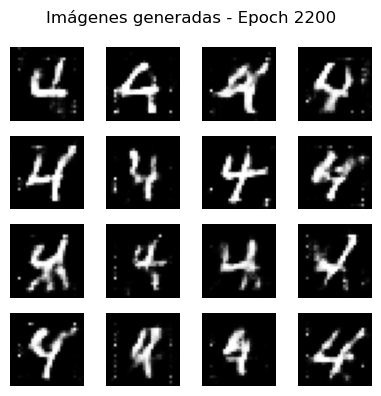

Epoch 2201
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2202
  D_real: 0.6835, D_fake: 0.6835, G: 1.0576
Epoch 2203
  D_real: 0.6836, D_fake: 0.6836, G: 1.0576
Epoch 2204
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2205
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2206
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2207
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2208
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2209
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2210
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2211
  D_real: 0.6835, D_fake: 0.6834, G: 1.0577
Epoch 2212
  D_real: 0.6833, D_fake: 0.6833, G: 1.0577
Epoch 2213
  D_real: 0.6833, D_fake: 0.6832, G: 1.0578
Epoch 2214
  D_real: 0.6832, D_fake: 0.6831, G: 1.0577
Epoch 2215
  D_real: 0.6831, D_fake: 0.6831, G: 1.0578
Epoch 2216
  D_real: 0.6831, D_fake: 0.6831, G: 1.0577
Epoch 2217
  D_real: 0.6831, D_fake: 0.6832, G: 1.0576
Epoch 2218
  D_real: 0.6832, D_fake: 0.6833, G: 1.0575
Epoch 2219

2025-04-24 19:18:59.403821: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


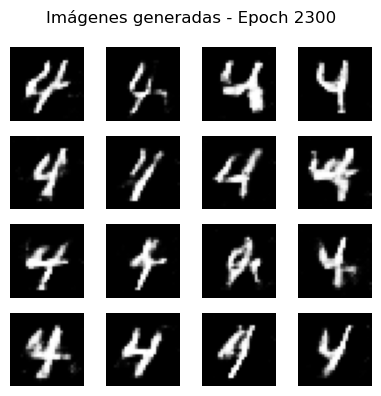

Epoch 2301
  D_real: 0.6814, D_fake: 0.6814, G: 1.0576
Epoch 2302
  D_real: 0.6814, D_fake: 0.6814, G: 1.0575
Epoch 2303
  D_real: 0.6814, D_fake: 0.6815, G: 1.0573
Epoch 2304
  D_real: 0.6815, D_fake: 0.6815, G: 1.0573
Epoch 2305
  D_real: 0.6816, D_fake: 0.6815, G: 1.0574
Epoch 2306
  D_real: 0.6815, D_fake: 0.6815, G: 1.0574
Epoch 2307
  D_real: 0.6815, D_fake: 0.6814, G: 1.0576
Epoch 2308
  D_real: 0.6814, D_fake: 0.6813, G: 1.0578
Epoch 2309
  D_real: 0.6813, D_fake: 0.6811, G: 1.0580
Epoch 2310
  D_real: 0.6811, D_fake: 0.6811, G: 1.0579
Epoch 2311
  D_real: 0.6811, D_fake: 0.6812, G: 1.0578
Epoch 2312
  D_real: 0.6811, D_fake: 0.6812, G: 1.0577
Epoch 2313
  D_real: 0.6812, D_fake: 0.6813, G: 1.0576
Epoch 2314
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2315
  D_real: 0.6813, D_fake: 0.6813, G: 1.0576
Epoch 2316
  D_real: 0.6814, D_fake: 0.6813, G: 1.0576
Epoch 2317
  D_real: 0.6813, D_fake: 0.6813, G: 1.0577
Epoch 2318
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2319

2025-04-24 19:19:12.453302: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


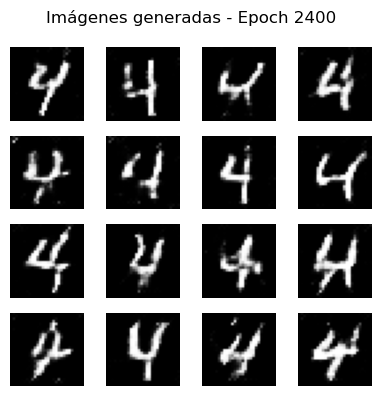

Epoch 2401
  D_real: 0.6780, D_fake: 0.6780, G: 1.0599
Epoch 2402
  D_real: 0.6779, D_fake: 0.6778, G: 1.0601
Epoch 2403
  D_real: 0.6778, D_fake: 0.6778, G: 1.0600
Epoch 2404
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2405
  D_real: 0.6777, D_fake: 0.6777, G: 1.0600
Epoch 2406
  D_real: 0.6777, D_fake: 0.6778, G: 1.0598
Epoch 2407
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2408
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2409
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2410
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2411
  D_real: 0.6777, D_fake: 0.6776, G: 1.0601
Epoch 2412
  D_real: 0.6776, D_fake: 0.6775, G: 1.0601
Epoch 2413
  D_real: 0.6775, D_fake: 0.6774, G: 1.0602
Epoch 2414
  D_real: 0.6774, D_fake: 0.6775, G: 1.0601
Epoch 2415
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2416
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2417
  D_real: 0.6775, D_fake: 0.6774, G: 1.0601
Epoch 2418
  D_real: 0.6773, D_fake: 0.6773, G: 1.0602
Epoch 2419

2025-04-24 19:19:25.227018: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


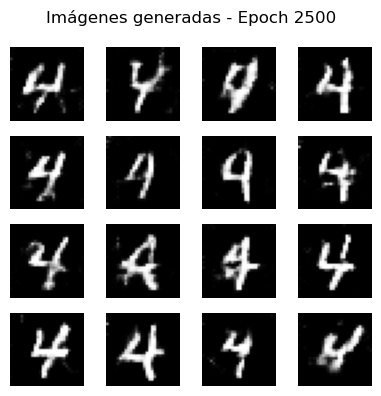

Epoch 2501
  D_real: 0.6741, D_fake: 0.6741, G: 1.0622
Epoch 2502
  D_real: 0.6741, D_fake: 0.6740, G: 1.0623
Epoch 2503
  D_real: 0.6740, D_fake: 0.6740, G: 1.0623
Epoch 2504
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2505
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2506
  D_real: 0.6739, D_fake: 0.6738, G: 1.0624
Epoch 2507
  D_real: 0.6738, D_fake: 0.6737, G: 1.0625
Epoch 2508
  D_real: 0.6738, D_fake: 0.6737, G: 1.0626
Epoch 2509
  D_real: 0.6737, D_fake: 0.6736, G: 1.0627
Epoch 2510
  D_real: 0.6736, D_fake: 0.6735, G: 1.0627
Epoch 2511
  D_real: 0.6735, D_fake: 0.6736, G: 1.0625
Epoch 2512
  D_real: 0.6736, D_fake: 0.6736, G: 1.0625
Epoch 2513
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2514
  D_real: 0.6736, D_fake: 0.6736, G: 1.0623
Epoch 2515
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2516
  D_real: 0.6737, D_fake: 0.6737, G: 1.0623
Epoch 2517
  D_real: 0.6738, D_fake: 0.6738, G: 1.0622
Epoch 2518
  D_real: 0.6738, D_fake: 0.6737, G: 1.0622
Epoch 2519

2025-04-24 19:19:38.284801: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


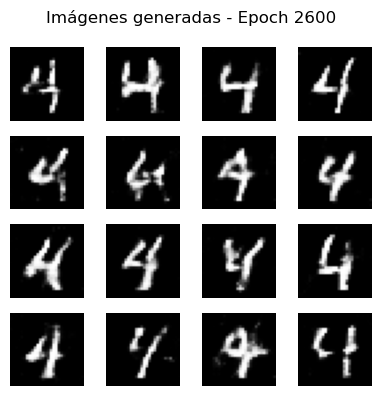

Epoch 2601
  D_real: 0.6720, D_fake: 0.6719, G: 1.0627
Epoch 2602
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2603
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2604
  D_real: 0.6719, D_fake: 0.6718, G: 1.0626
Epoch 2605
  D_real: 0.6718, D_fake: 0.6718, G: 1.0627
Epoch 2606
  D_real: 0.6717, D_fake: 0.6718, G: 1.0626
Epoch 2607
  D_real: 0.6717, D_fake: 0.6717, G: 1.0626
Epoch 2608
  D_real: 0.6717, D_fake: 0.6718, G: 1.0625
Epoch 2609
  D_real: 0.6718, D_fake: 0.6719, G: 1.0624
Epoch 2610
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2611
  D_real: 0.6721, D_fake: 0.6720, G: 1.0624
Epoch 2612
  D_real: 0.6721, D_fake: 0.6721, G: 1.0624
Epoch 2613
  D_real: 0.6721, D_fake: 0.6720, G: 1.0625
Epoch 2614
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2615
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2616
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2617
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2618
  D_real: 0.6720, D_fake: 0.6719, G: 1.0623
Epoch 2619

2025-04-24 19:19:51.279871: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


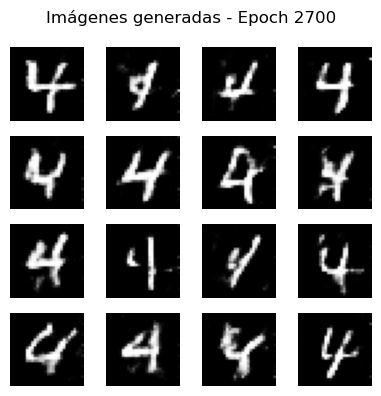

Epoch 2701
  D_real: 0.6697, D_fake: 0.6696, G: 1.0639
Epoch 2702
  D_real: 0.6696, D_fake: 0.6696, G: 1.0638
Epoch 2703
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2704
  D_real: 0.6697, D_fake: 0.6696, G: 1.0638
Epoch 2705
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2706
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2707
  D_real: 0.6696, D_fake: 0.6695, G: 1.0640
Epoch 2708
  D_real: 0.6695, D_fake: 0.6694, G: 1.0641
Epoch 2709
  D_real: 0.6694, D_fake: 0.6693, G: 1.0643
Epoch 2710
  D_real: 0.6693, D_fake: 0.6693, G: 1.0642
Epoch 2711
  D_real: 0.6693, D_fake: 0.6692, G: 1.0643
Epoch 2712
  D_real: 0.6692, D_fake: 0.6692, G: 1.0643
Epoch 2713
  D_real: 0.6692, D_fake: 0.6692, G: 1.0642
Epoch 2714
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2715
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2716
  D_real: 0.6692, D_fake: 0.6692, G: 1.0640
Epoch 2717
  D_real: 0.6693, D_fake: 0.6693, G: 1.0639
Epoch 2718
  D_real: 0.6693, D_fake: 0.6694, G: 1.0639
Epoch 2719

2025-04-24 19:20:04.312947: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


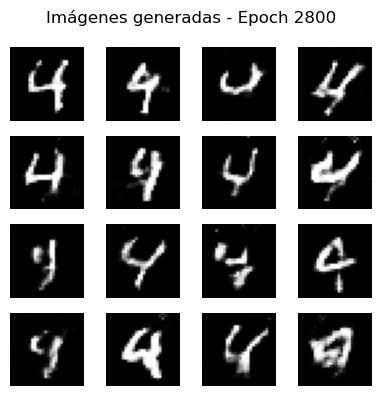

Epoch 2801
  D_real: 0.6674, D_fake: 0.6673, G: 1.0655
Epoch 2802
  D_real: 0.6673, D_fake: 0.6672, G: 1.0657
Epoch 2803
  D_real: 0.6672, D_fake: 0.6671, G: 1.0658
Epoch 2804
  D_real: 0.6671, D_fake: 0.6671, G: 1.0657
Epoch 2805
  D_real: 0.6672, D_fake: 0.6673, G: 1.0657
Epoch 2806
  D_real: 0.6672, D_fake: 0.6673, G: 1.0655
Epoch 2807
  D_real: 0.6674, D_fake: 0.6674, G: 1.0654
Epoch 2808
  D_real: 0.6675, D_fake: 0.6675, G: 1.0654
Epoch 2809
  D_real: 0.6675, D_fake: 0.6674, G: 1.0655
Epoch 2810
  D_real: 0.6675, D_fake: 0.6674, G: 1.0657
Epoch 2811
  D_real: 0.6675, D_fake: 0.6674, G: 1.0659
Epoch 2812
  D_real: 0.6674, D_fake: 0.6673, G: 1.0661
Epoch 2813
  D_real: 0.6673, D_fake: 0.6672, G: 1.0662
Epoch 2814
  D_real: 0.6672, D_fake: 0.6671, G: 1.0663
Epoch 2815
  D_real: 0.6671, D_fake: 0.6670, G: 1.0664
Epoch 2816
  D_real: 0.6669, D_fake: 0.6669, G: 1.0664
Epoch 2817
  D_real: 0.6669, D_fake: 0.6669, G: 1.0663
Epoch 2818
  D_real: 0.6669, D_fake: 0.6669, G: 1.0662
Epoch 2819

2025-04-24 19:20:17.373945: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


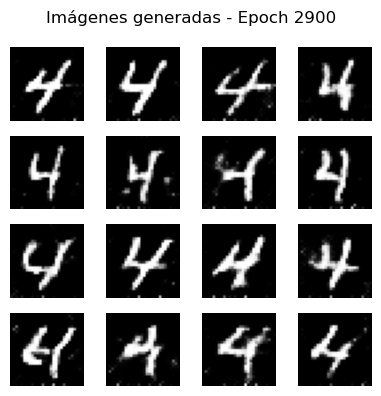

Epoch 2901
  D_real: 0.6636, D_fake: 0.6636, G: 1.0690
Epoch 2902
  D_real: 0.6636, D_fake: 0.6635, G: 1.0691
Epoch 2903
  D_real: 0.6635, D_fake: 0.6635, G: 1.0691
Epoch 2904
  D_real: 0.6635, D_fake: 0.6634, G: 1.0691
Epoch 2905
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2906
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2907
  D_real: 0.6633, D_fake: 0.6633, G: 1.0692
Epoch 2908
  D_real: 0.6632, D_fake: 0.6632, G: 1.0691
Epoch 2909
  D_real: 0.6633, D_fake: 0.6633, G: 1.0691
Epoch 2910
  D_real: 0.6633, D_fake: 0.6632, G: 1.0692
Epoch 2911
  D_real: 0.6632, D_fake: 0.6632, G: 1.0692
Epoch 2912
  D_real: 0.6631, D_fake: 0.6632, G: 1.0692
Epoch 2913
  D_real: 0.6632, D_fake: 0.6631, G: 1.0693
Epoch 2914
  D_real: 0.6632, D_fake: 0.6631, G: 1.0694
Epoch 2915
  D_real: 0.6631, D_fake: 0.6631, G: 1.0694
Epoch 2916
  D_real: 0.6631, D_fake: 0.6631, G: 1.0693
Epoch 2917
  D_real: 0.6631, D_fake: 0.6630, G: 1.0694
Epoch 2918
  D_real: 0.6630, D_fake: 0.6630, G: 1.0693
Epoch 2919

2025-04-24 19:20:30.998563: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


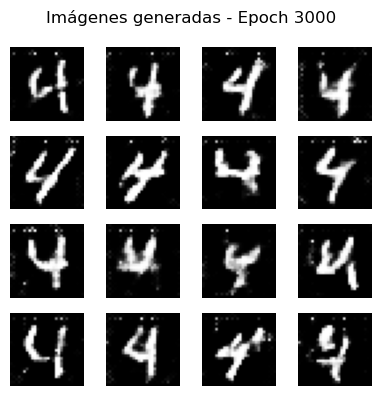

Epoch 3001
  D_real: 0.6605, D_fake: 0.6605, G: 1.0706
Epoch 3002
  D_real: 0.6605, D_fake: 0.6605, G: 1.0705
Epoch 3003
  D_real: 0.6606, D_fake: 0.6606, G: 1.0704
Epoch 3004
  D_real: 0.6607, D_fake: 0.6606, G: 1.0704
Epoch 3005
  D_real: 0.6607, D_fake: 0.6607, G: 1.0704
Epoch 3006
  D_real: 0.6608, D_fake: 0.6608, G: 1.0704
Epoch 3007
  D_real: 0.6608, D_fake: 0.6608, G: 1.0704
Epoch 3008
  D_real: 0.6608, D_fake: 0.6607, G: 1.0705
Epoch 3009
  D_real: 0.6607, D_fake: 0.6606, G: 1.0707
Epoch 3010
  D_real: 0.6606, D_fake: 0.6605, G: 1.0709
Epoch 3011
  D_real: 0.6605, D_fake: 0.6604, G: 1.0712
Epoch 3012
  D_real: 0.6604, D_fake: 0.6603, G: 1.0714
Epoch 3013
  D_real: 0.6602, D_fake: 0.6602, G: 1.0714
Epoch 3014
  D_real: 0.6601, D_fake: 0.6601, G: 1.0714
Epoch 3015
  D_real: 0.6600, D_fake: 0.6601, G: 1.0714
Epoch 3016
  D_real: 0.6600, D_fake: 0.6600, G: 1.0714
Epoch 3017
  D_real: 0.6600, D_fake: 0.6600, G: 1.0716
Epoch 3018
  D_real: 0.6600, D_fake: 0.6599, G: 1.0719
Epoch 3019

2025-04-24 19:20:44.259870: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


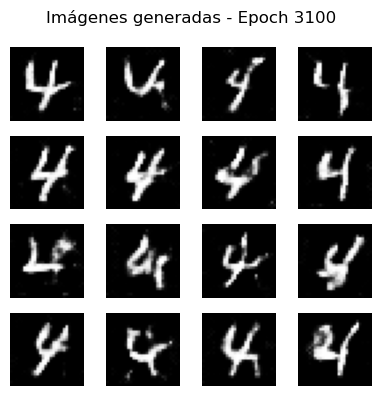

Epoch 3101
  D_real: 0.6572, D_fake: 0.6572, G: 1.0743
Epoch 3102
  D_real: 0.6572, D_fake: 0.6571, G: 1.0743
Epoch 3103
  D_real: 0.6571, D_fake: 0.6570, G: 1.0745
Epoch 3104
  D_real: 0.6570, D_fake: 0.6569, G: 1.0745
Epoch 3105
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3106
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3107
  D_real: 0.6570, D_fake: 0.6570, G: 1.0744
Epoch 3108
  D_real: 0.6570, D_fake: 0.6570, G: 1.0744
Epoch 3109
  D_real: 0.6570, D_fake: 0.6569, G: 1.0744
Epoch 3110
  D_real: 0.6569, D_fake: 0.6569, G: 1.0743
Epoch 3111
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3112
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3113
  D_real: 0.6569, D_fake: 0.6570, G: 1.0743
Epoch 3114
  D_real: 0.6570, D_fake: 0.6569, G: 1.0744
Epoch 3115
  D_real: 0.6569, D_fake: 0.6568, G: 1.0745
Epoch 3116
  D_real: 0.6568, D_fake: 0.6568, G: 1.0746
Epoch 3117
  D_real: 0.6567, D_fake: 0.6567, G: 1.0747
Epoch 3118
  D_real: 0.6567, D_fake: 0.6566, G: 1.0747
Epoch 3119

2025-04-24 19:20:57.087443: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


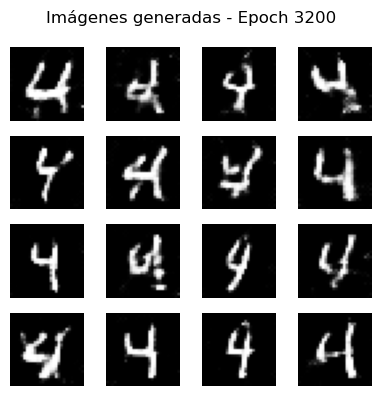

Epoch 3201
  D_real: 0.6548, D_fake: 0.6547, G: 1.0761
Epoch 3202
  D_real: 0.6547, D_fake: 0.6546, G: 1.0762
Epoch 3203
  D_real: 0.6546, D_fake: 0.6546, G: 1.0763
Epoch 3204
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3205
  D_real: 0.6546, D_fake: 0.6546, G: 1.0761
Epoch 3206
  D_real: 0.6546, D_fake: 0.6547, G: 1.0760
Epoch 3207
  D_real: 0.6547, D_fake: 0.6547, G: 1.0760
Epoch 3208
  D_real: 0.6547, D_fake: 0.6547, G: 1.0760
Epoch 3209
  D_real: 0.6548, D_fake: 0.6547, G: 1.0761
Epoch 3210
  D_real: 0.6547, D_fake: 0.6547, G: 1.0761
Epoch 3211
  D_real: 0.6547, D_fake: 0.6547, G: 1.0762
Epoch 3212
  D_real: 0.6546, D_fake: 0.6546, G: 1.0763
Epoch 3213
  D_real: 0.6546, D_fake: 0.6545, G: 1.0763
Epoch 3214
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3215
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3216
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3217
  D_real: 0.6545, D_fake: 0.6545, G: 1.0763
Epoch 3218
  D_real: 0.6545, D_fake: 0.6546, G: 1.0762
Epoch 3219

2025-04-24 19:21:10.134676: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


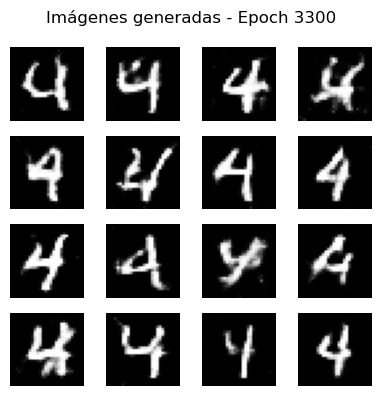

Epoch 3301
  D_real: 0.6523, D_fake: 0.6524, G: 1.0779
Epoch 3302
  D_real: 0.6524, D_fake: 0.6524, G: 1.0778
Epoch 3303
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3304
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3305
  D_real: 0.6525, D_fake: 0.6525, G: 1.0779
Epoch 3306
  D_real: 0.6525, D_fake: 0.6524, G: 1.0781
Epoch 3307
  D_real: 0.6525, D_fake: 0.6524, G: 1.0781
Epoch 3308
  D_real: 0.6524, D_fake: 0.6524, G: 1.0782
Epoch 3309
  D_real: 0.6523, D_fake: 0.6523, G: 1.0781
Epoch 3310
  D_real: 0.6524, D_fake: 0.6524, G: 1.0780
Epoch 3311
  D_real: 0.6524, D_fake: 0.6524, G: 1.0779
Epoch 3312
  D_real: 0.6524, D_fake: 0.6524, G: 1.0779
Epoch 3313
  D_real: 0.6524, D_fake: 0.6525, G: 1.0778
Epoch 3314
  D_real: 0.6525, D_fake: 0.6525, G: 1.0777
Epoch 3315
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3316
  D_real: 0.6526, D_fake: 0.6526, G: 1.0778
Epoch 3317
  D_real: 0.6526, D_fake: 0.6526, G: 1.0779
Epoch 3318
  D_real: 0.6526, D_fake: 0.6525, G: 1.0779
Epoch 3319

2025-04-24 19:21:24.090504: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


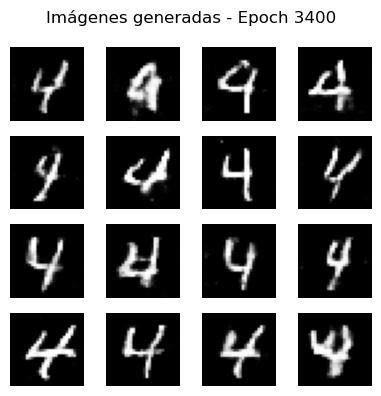

Epoch 3401
  D_real: 0.6509, D_fake: 0.6509, G: 1.0788
Epoch 3402
  D_real: 0.6508, D_fake: 0.6508, G: 1.0788
Epoch 3403
  D_real: 0.6508, D_fake: 0.6508, G: 1.0789
Epoch 3404
  D_real: 0.6508, D_fake: 0.6509, G: 1.0788
Epoch 3405
  D_real: 0.6509, D_fake: 0.6508, G: 1.0788
Epoch 3406
  D_real: 0.6508, D_fake: 0.6508, G: 1.0788
Epoch 3407
  D_real: 0.6508, D_fake: 0.6507, G: 1.0788
Epoch 3408
  D_real: 0.6507, D_fake: 0.6506, G: 1.0789
Epoch 3409
  D_real: 0.6506, D_fake: 0.6506, G: 1.0790
Epoch 3410
  D_real: 0.6506, D_fake: 0.6505, G: 1.0791
Epoch 3411
  D_real: 0.6505, D_fake: 0.6505, G: 1.0791
Epoch 3412
  D_real: 0.6504, D_fake: 0.6504, G: 1.0790
Epoch 3413
  D_real: 0.6504, D_fake: 0.6504, G: 1.0790
Epoch 3414
  D_real: 0.6505, D_fake: 0.6504, G: 1.0790
Epoch 3415
  D_real: 0.6505, D_fake: 0.6504, G: 1.0791
Epoch 3416
  D_real: 0.6504, D_fake: 0.6503, G: 1.0792
Epoch 3417
  D_real: 0.6503, D_fake: 0.6502, G: 1.0793
Epoch 3418
  D_real: 0.6502, D_fake: 0.6501, G: 1.0794
Epoch 3419

2025-04-24 19:21:37.691520: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


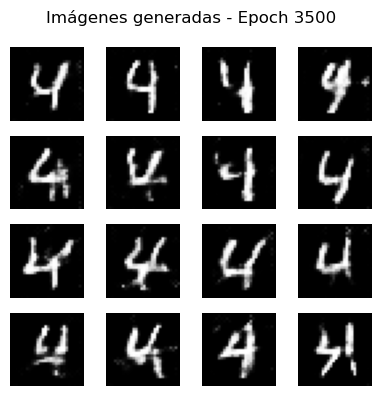

Epoch 3501
  D_real: 0.6481, D_fake: 0.6481, G: 1.0827
Epoch 3502
  D_real: 0.6481, D_fake: 0.6480, G: 1.0829
Epoch 3503
  D_real: 0.6480, D_fake: 0.6479, G: 1.0830
Epoch 3504
  D_real: 0.6479, D_fake: 0.6478, G: 1.0831
Epoch 3505
  D_real: 0.6478, D_fake: 0.6477, G: 1.0832
Epoch 3506
  D_real: 0.6477, D_fake: 0.6477, G: 1.0832
Epoch 3507
  D_real: 0.6477, D_fake: 0.6477, G: 1.0832
Epoch 3508
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3509
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3510
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3511
  D_real: 0.6476, D_fake: 0.6476, G: 1.0831
Epoch 3512
  D_real: 0.6477, D_fake: 0.6477, G: 1.0831
Epoch 3513
  D_real: 0.6477, D_fake: 0.6477, G: 1.0830
Epoch 3514
  D_real: 0.6478, D_fake: 0.6478, G: 1.0830
Epoch 3515
  D_real: 0.6479, D_fake: 0.6478, G: 1.0830
Epoch 3516
  D_real: 0.6478, D_fake: 0.6479, G: 1.0830
Epoch 3517
  D_real: 0.6479, D_fake: 0.6478, G: 1.0833
Epoch 3518
  D_real: 0.6478, D_fake: 0.6477, G: 1.0835
Epoch 3519

2025-04-24 19:21:50.581209: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


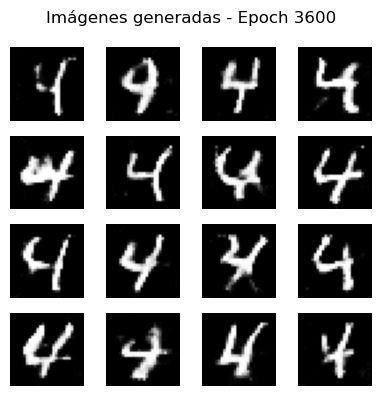

Epoch 3601
  D_real: 0.6451, D_fake: 0.6451, G: 1.0868
Epoch 3602
  D_real: 0.6451, D_fake: 0.6452, G: 1.0867
Epoch 3603
  D_real: 0.6452, D_fake: 0.6452, G: 1.0866
Epoch 3604
  D_real: 0.6452, D_fake: 0.6452, G: 1.0866
Epoch 3605
  D_real: 0.6452, D_fake: 0.6451, G: 1.0867
Epoch 3606
  D_real: 0.6452, D_fake: 0.6452, G: 1.0868
Epoch 3607
  D_real: 0.6451, D_fake: 0.6451, G: 1.0869
Epoch 3608
  D_real: 0.6451, D_fake: 0.6450, G: 1.0870
Epoch 3609
  D_real: 0.6450, D_fake: 0.6450, G: 1.0870
Epoch 3610
  D_real: 0.6450, D_fake: 0.6450, G: 1.0870
Epoch 3611
  D_real: 0.6450, D_fake: 0.6449, G: 1.0870
Epoch 3612
  D_real: 0.6449, D_fake: 0.6448, G: 1.0871
Epoch 3613
  D_real: 0.6448, D_fake: 0.6448, G: 1.0871
Epoch 3614
  D_real: 0.6448, D_fake: 0.6447, G: 1.0871
Epoch 3615
  D_real: 0.6447, D_fake: 0.6448, G: 1.0870
Epoch 3616
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3617
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3618
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3619

2025-04-24 19:22:03.344899: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


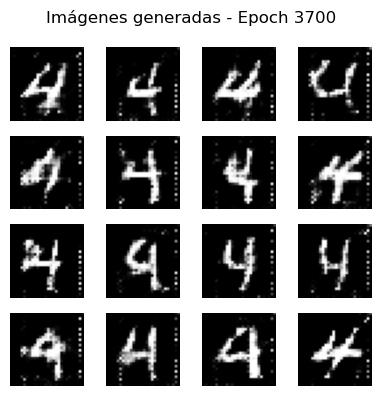

Epoch 3701
  D_real: 0.6408, D_fake: 0.6408, G: 1.0962
Epoch 3702
  D_real: 0.6407, D_fake: 0.6407, G: 1.0967
Epoch 3703
  D_real: 0.6406, D_fake: 0.6405, G: 1.0975
Epoch 3704
  D_real: 0.6405, D_fake: 0.6404, G: 1.0987
Epoch 3705
  D_real: 0.6404, D_fake: 0.6403, G: 1.1000
Epoch 3706
  D_real: 0.6403, D_fake: 0.6402, G: 1.1013
Epoch 3707
  D_real: 0.6401, D_fake: 0.6400, G: 1.1026
Epoch 3708
  D_real: 0.6400, D_fake: 0.6399, G: 1.1038
Epoch 3709
  D_real: 0.6399, D_fake: 0.6398, G: 1.1049
Epoch 3710
  D_real: 0.6398, D_fake: 0.6397, G: 1.1059
Epoch 3711
  D_real: 0.6396, D_fake: 0.6396, G: 1.1066
Epoch 3712
  D_real: 0.6395, D_fake: 0.6394, G: 1.1073
Epoch 3713
  D_real: 0.6394, D_fake: 0.6393, G: 1.1079
Epoch 3714
  D_real: 0.6393, D_fake: 0.6392, G: 1.1086
Epoch 3715
  D_real: 0.6391, D_fake: 0.6391, G: 1.1091
Epoch 3716
  D_real: 0.6390, D_fake: 0.6389, G: 1.1097
Epoch 3717
  D_real: 0.6389, D_fake: 0.6388, G: 1.1100
Epoch 3718
  D_real: 0.6388, D_fake: 0.6387, G: 1.1105
Epoch 3719

2025-04-24 19:22:16.462644: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


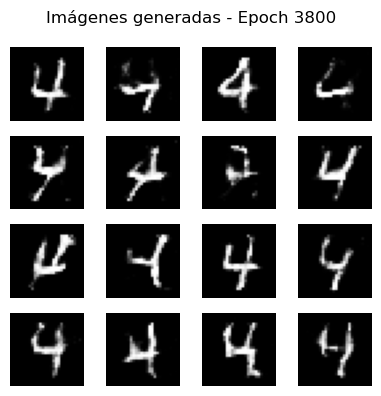

Epoch 3801
  D_real: 0.6353, D_fake: 0.6353, G: 1.1161
Epoch 3802
  D_real: 0.6353, D_fake: 0.6352, G: 1.1164
Epoch 3803
  D_real: 0.6351, D_fake: 0.6351, G: 1.1166
Epoch 3804
  D_real: 0.6351, D_fake: 0.6350, G: 1.1165
Epoch 3805
  D_real: 0.6350, D_fake: 0.6350, G: 1.1165
Epoch 3806
  D_real: 0.6350, D_fake: 0.6349, G: 1.1164
Epoch 3807
  D_real: 0.6349, D_fake: 0.6349, G: 1.1164
Epoch 3808
  D_real: 0.6349, D_fake: 0.6348, G: 1.1166
Epoch 3809
  D_real: 0.6348, D_fake: 0.6347, G: 1.1168
Epoch 3810
  D_real: 0.6347, D_fake: 0.6347, G: 1.1168
Epoch 3811
  D_real: 0.6347, D_fake: 0.6347, G: 1.1168
Epoch 3812
  D_real: 0.6347, D_fake: 0.6347, G: 1.1167
Epoch 3813
  D_real: 0.6347, D_fake: 0.6346, G: 1.1168
Epoch 3814
  D_real: 0.6346, D_fake: 0.6347, G: 1.1167
Epoch 3815
  D_real: 0.6348, D_fake: 0.6348, G: 1.1167
Epoch 3816
  D_real: 0.6348, D_fake: 0.6347, G: 1.1167
Epoch 3817
  D_real: 0.6348, D_fake: 0.6348, G: 1.1166
Epoch 3818
  D_real: 0.6348, D_fake: 0.6348, G: 1.1166
Epoch 3819

2025-04-24 19:22:29.167669: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


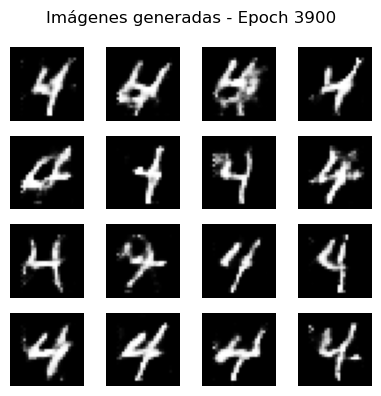

Epoch 3901
  D_real: 0.6334, D_fake: 0.6333, G: 1.1179
Epoch 3902
  D_real: 0.6333, D_fake: 0.6333, G: 1.1180
Epoch 3903
  D_real: 0.6332, D_fake: 0.6333, G: 1.1178
Epoch 3904
  D_real: 0.6333, D_fake: 0.6334, G: 1.1178
Epoch 3905
  D_real: 0.6334, D_fake: 0.6334, G: 1.1177
Epoch 3906
  D_real: 0.6334, D_fake: 0.6333, G: 1.1178
Epoch 3907
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3908
  D_real: 0.6334, D_fake: 0.6333, G: 1.1178
Epoch 3909
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3910
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3911
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3912
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3913
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3914
  D_real: 0.6336, D_fake: 0.6336, G: 1.1177
Epoch 3915
  D_real: 0.6336, D_fake: 0.6335, G: 1.1179
Epoch 3916
  D_real: 0.6335, D_fake: 0.6335, G: 1.1180
Epoch 3917
  D_real: 0.6335, D_fake: 0.6335, G: 1.1181
Epoch 3918
  D_real: 0.6335, D_fake: 0.6335, G: 1.1180
Epoch 3919

2025-04-24 19:22:41.792659: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


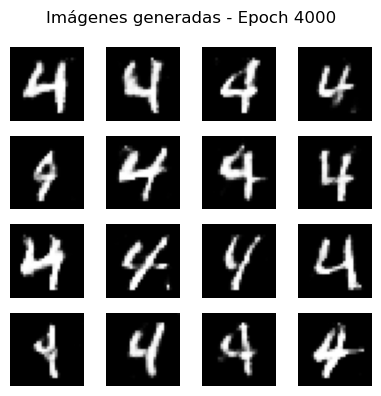

Epoch 4001
  D_real: 0.6323, D_fake: 0.6322, G: 1.1187
Epoch 4002
  D_real: 0.6322, D_fake: 0.6322, G: 1.1188
Epoch 4003
  D_real: 0.6323, D_fake: 0.6322, G: 1.1188
Epoch 4004
  D_real: 0.6322, D_fake: 0.6323, G: 1.1187
Epoch 4005
  D_real: 0.6322, D_fake: 0.6322, G: 1.1187
Epoch 4006
  D_real: 0.6323, D_fake: 0.6323, G: 1.1187
Epoch 4007
  D_real: 0.6323, D_fake: 0.6323, G: 1.1187
Epoch 4008
  D_real: 0.6323, D_fake: 0.6323, G: 1.1188
Epoch 4009
  D_real: 0.6323, D_fake: 0.6323, G: 1.1188
Epoch 4010
  D_real: 0.6323, D_fake: 0.6322, G: 1.1188
Epoch 4011
  D_real: 0.6322, D_fake: 0.6322, G: 1.1189
Epoch 4012
  D_real: 0.6322, D_fake: 0.6322, G: 1.1191
Epoch 4013
  D_real: 0.6321, D_fake: 0.6321, G: 1.1191
Epoch 4014
  D_real: 0.6321, D_fake: 0.6321, G: 1.1191
Epoch 4015
  D_real: 0.6320, D_fake: 0.6320, G: 1.1190
Epoch 4016
  D_real: 0.6320, D_fake: 0.6320, G: 1.1190
Epoch 4017
  D_real: 0.6320, D_fake: 0.6319, G: 1.1191
Epoch 4018
  D_real: 0.6320, D_fake: 0.6319, G: 1.1193
Epoch 4019

2025-04-24 19:22:54.638449: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


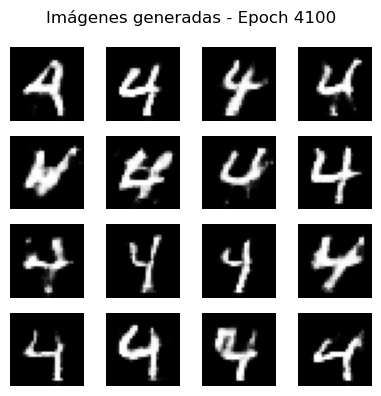

Epoch 4101
  D_real: 0.6309, D_fake: 0.6309, G: 1.1201
Epoch 4102
  D_real: 0.6309, D_fake: 0.6310, G: 1.1200
Epoch 4103
  D_real: 0.6310, D_fake: 0.6310, G: 1.1200
Epoch 4104
  D_real: 0.6310, D_fake: 0.6310, G: 1.1201
Epoch 4105
  D_real: 0.6310, D_fake: 0.6309, G: 1.1201
Epoch 4106
  D_real: 0.6309, D_fake: 0.6309, G: 1.1201
Epoch 4107
  D_real: 0.6309, D_fake: 0.6308, G: 1.1202
Epoch 4108
  D_real: 0.6308, D_fake: 0.6308, G: 1.1202
Epoch 4109
  D_real: 0.6308, D_fake: 0.6307, G: 1.1202
Epoch 4110
  D_real: 0.6307, D_fake: 0.6307, G: 1.1202
Epoch 4111
  D_real: 0.6307, D_fake: 0.6307, G: 1.1203
Epoch 4112
  D_real: 0.6307, D_fake: 0.6307, G: 1.1203
Epoch 4113
  D_real: 0.6307, D_fake: 0.6307, G: 1.1202
Epoch 4114
  D_real: 0.6307, D_fake: 0.6307, G: 1.1203
Epoch 4115
  D_real: 0.6307, D_fake: 0.6306, G: 1.1203
Epoch 4116
  D_real: 0.6307, D_fake: 0.6306, G: 1.1204
Epoch 4117
  D_real: 0.6306, D_fake: 0.6306, G: 1.1205
Epoch 4118
  D_real: 0.6306, D_fake: 0.6306, G: 1.1203
Epoch 4119

2025-04-24 19:23:07.794084: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


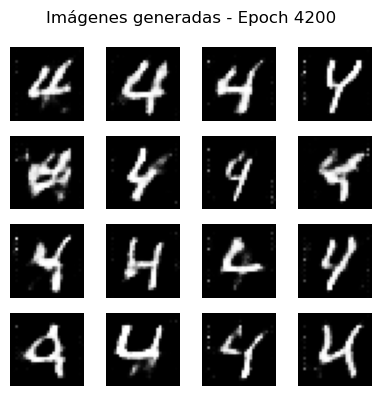

Epoch 4201
  D_real: 0.6280, D_fake: 0.6280, G: 1.1239
Epoch 4202
  D_real: 0.6279, D_fake: 0.6279, G: 1.1239
Epoch 4203
  D_real: 0.6279, D_fake: 0.6278, G: 1.1239
Epoch 4204
  D_real: 0.6278, D_fake: 0.6277, G: 1.1239
Epoch 4205
  D_real: 0.6277, D_fake: 0.6277, G: 1.1240
Epoch 4206
  D_real: 0.6277, D_fake: 0.6277, G: 1.1239
Epoch 4207
  D_real: 0.6278, D_fake: 0.6280, G: 1.1237
Epoch 4208
  D_real: 0.6281, D_fake: 0.6282, G: 1.1236
Epoch 4209
  D_real: 0.6282, D_fake: 0.6283, G: 1.1235
Epoch 4210
  D_real: 0.6283, D_fake: 0.6283, G: 1.1237
Epoch 4211
  D_real: 0.6283, D_fake: 0.6282, G: 1.1242
Epoch 4212
  D_real: 0.6282, D_fake: 0.6281, G: 1.1247
Epoch 4213
  D_real: 0.6281, D_fake: 0.6280, G: 1.1255
Epoch 4214
  D_real: 0.6280, D_fake: 0.6279, G: 1.1260
Epoch 4215
  D_real: 0.6279, D_fake: 0.6278, G: 1.1265
Epoch 4216
  D_real: 0.6278, D_fake: 0.6277, G: 1.1267
Epoch 4217
  D_real: 0.6277, D_fake: 0.6277, G: 1.1267
Epoch 4218
  D_real: 0.6276, D_fake: 0.6276, G: 1.1269
Epoch 4219

2025-04-24 19:23:20.654606: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


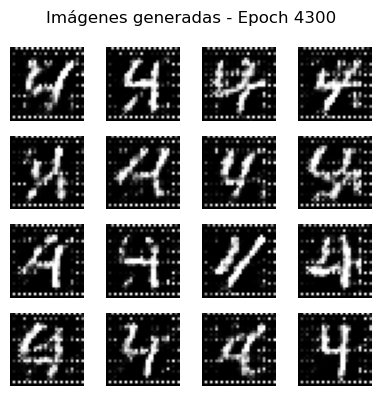

Epoch 4301
  D_real: 0.6201, D_fake: 0.6200, G: 1.1529
Epoch 4302
  D_real: 0.6200, D_fake: 0.6200, G: 1.1532
Epoch 4303
  D_real: 0.6199, D_fake: 0.6199, G: 1.1534
Epoch 4304
  D_real: 0.6198, D_fake: 0.6197, G: 1.1541
Epoch 4305
  D_real: 0.6197, D_fake: 0.6197, G: 1.1549
Epoch 4306
  D_real: 0.6196, D_fake: 0.6195, G: 1.1554
Epoch 4307
  D_real: 0.6195, D_fake: 0.6194, G: 1.1559
Epoch 4308
  D_real: 0.6194, D_fake: 0.6193, G: 1.1565
Epoch 4309
  D_real: 0.6193, D_fake: 0.6192, G: 1.1573
Epoch 4310
  D_real: 0.6192, D_fake: 0.6191, G: 1.1577
Epoch 4311
  D_real: 0.6191, D_fake: 0.6190, G: 1.1582
Epoch 4312
  D_real: 0.6190, D_fake: 0.6189, G: 1.1589
Epoch 4313
  D_real: 0.6189, D_fake: 0.6188, G: 1.1596
Epoch 4314
  D_real: 0.6188, D_fake: 0.6187, G: 1.1599
Epoch 4315
  D_real: 0.6187, D_fake: 0.6186, G: 1.1604
Epoch 4316
  D_real: 0.6186, D_fake: 0.6185, G: 1.1611
Epoch 4317
  D_real: 0.6185, D_fake: 0.6184, G: 1.1614
Epoch 4318
  D_real: 0.6184, D_fake: 0.6183, G: 1.1617
Epoch 4319

2025-04-24 19:23:33.394273: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


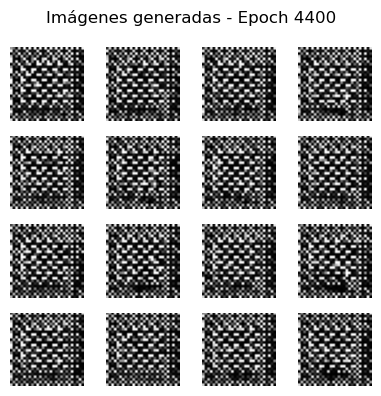

Epoch 4401
  D_real: 0.6102, D_fake: 0.6101, G: 1.3661
Epoch 4402
  D_real: 0.6101, D_fake: 0.6100, G: 1.3683
Epoch 4403
  D_real: 0.6100, D_fake: 0.6099, G: 1.3707
Epoch 4404
  D_real: 0.6099, D_fake: 0.6098, G: 1.3728
Epoch 4405
  D_real: 0.6098, D_fake: 0.6097, G: 1.3752
Epoch 4406
  D_real: 0.6097, D_fake: 0.6096, G: 1.3773
Epoch 4407
  D_real: 0.6096, D_fake: 0.6095, G: 1.3798
Epoch 4408
  D_real: 0.6095, D_fake: 0.6094, G: 1.3819
Epoch 4409
  D_real: 0.6094, D_fake: 0.6093, G: 1.3839
Epoch 4410
  D_real: 0.6093, D_fake: 0.6092, G: 1.3862
Epoch 4411
  D_real: 0.6092, D_fake: 0.6091, G: 1.3882
Epoch 4412
  D_real: 0.6091, D_fake: 0.6090, G: 1.3905
Epoch 4413
  D_real: 0.6090, D_fake: 0.6089, G: 1.3925
Epoch 4414
  D_real: 0.6089, D_fake: 0.6088, G: 1.3949
Epoch 4415
  D_real: 0.6088, D_fake: 0.6087, G: 1.3970
Epoch 4416
  D_real: 0.6087, D_fake: 0.6086, G: 1.3991
Epoch 4417
  D_real: 0.6086, D_fake: 0.6085, G: 1.4010
Epoch 4418
  D_real: 0.6085, D_fake: 0.6084, G: 1.4032
Epoch 4419

2025-04-24 19:23:46.049011: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


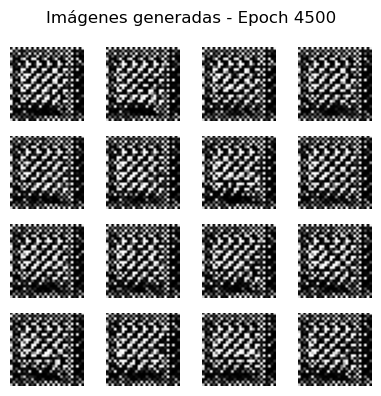

Epoch 4501
  D_real: 0.6005, D_fake: 0.6004, G: 1.5312
Epoch 4502
  D_real: 0.6004, D_fake: 0.6004, G: 1.5323
Epoch 4503
  D_real: 0.6003, D_fake: 0.6003, G: 1.5333
Epoch 4504
  D_real: 0.6002, D_fake: 0.6002, G: 1.5343
Epoch 4505
  D_real: 0.6001, D_fake: 0.6001, G: 1.5352
Epoch 4506
  D_real: 0.6000, D_fake: 0.6000, G: 1.5363
Epoch 4507
  D_real: 0.5999, D_fake: 0.5999, G: 1.5372
Epoch 4508
  D_real: 0.5998, D_fake: 0.5998, G: 1.5384
Epoch 4509
  D_real: 0.5998, D_fake: 0.5997, G: 1.5393
Epoch 4510
  D_real: 0.5997, D_fake: 0.5996, G: 1.5405
Epoch 4511
  D_real: 0.5996, D_fake: 0.5995, G: 1.5412
Epoch 4512
  D_real: 0.5995, D_fake: 0.5994, G: 1.5421
Epoch 4513
  D_real: 0.5994, D_fake: 0.5993, G: 1.5430
Epoch 4514
  D_real: 0.5993, D_fake: 0.5992, G: 1.5438
Epoch 4515
  D_real: 0.5992, D_fake: 0.5991, G: 1.5446
Epoch 4516
  D_real: 0.5991, D_fake: 0.5990, G: 1.5454
Epoch 4517
  D_real: 0.5990, D_fake: 0.5989, G: 1.5462
Epoch 4518
  D_real: 0.5989, D_fake: 0.5988, G: 1.5471
Epoch 4519

2025-04-24 19:23:59.292097: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


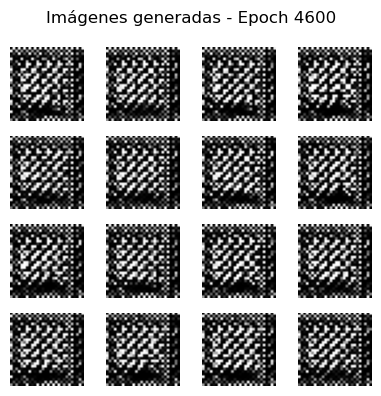

Epoch 4601
  D_real: 0.5913, D_fake: 0.5912, G: 1.6096
Epoch 4602
  D_real: 0.5912, D_fake: 0.5911, G: 1.6102
Epoch 4603
  D_real: 0.5911, D_fake: 0.5910, G: 1.6109
Epoch 4604
  D_real: 0.5910, D_fake: 0.5909, G: 1.6116
Epoch 4605
  D_real: 0.5909, D_fake: 0.5908, G: 1.6123
Epoch 4606
  D_real: 0.5908, D_fake: 0.5907, G: 1.6131
Epoch 4607
  D_real: 0.5907, D_fake: 0.5907, G: 1.6139
Epoch 4608
  D_real: 0.5906, D_fake: 0.5906, G: 1.6146
Epoch 4609
  D_real: 0.5905, D_fake: 0.5905, G: 1.6152
Epoch 4610
  D_real: 0.5904, D_fake: 0.5904, G: 1.6160
Epoch 4611
  D_real: 0.5903, D_fake: 0.5903, G: 1.6167
Epoch 4612
  D_real: 0.5903, D_fake: 0.5902, G: 1.6174
Epoch 4613
  D_real: 0.5902, D_fake: 0.5901, G: 1.6182
Epoch 4614
  D_real: 0.5901, D_fake: 0.5900, G: 1.6189
Epoch 4615
  D_real: 0.5900, D_fake: 0.5899, G: 1.6196
Epoch 4616
  D_real: 0.5899, D_fake: 0.5898, G: 1.6203
Epoch 4617
  D_real: 0.5898, D_fake: 0.5897, G: 1.6210
Epoch 4618
  D_real: 0.5897, D_fake: 0.5897, G: 1.6219
Epoch 4619

2025-04-24 19:24:12.160930: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


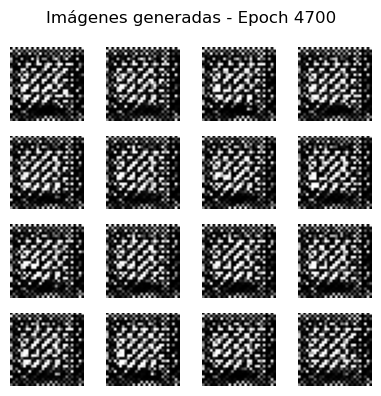

Epoch 4701
  D_real: 0.5824, D_fake: 0.5823, G: 1.6845
Epoch 4702
  D_real: 0.5823, D_fake: 0.5822, G: 1.6852
Epoch 4703
  D_real: 0.5822, D_fake: 0.5821, G: 1.6861
Epoch 4704
  D_real: 0.5821, D_fake: 0.5821, G: 1.6869
Epoch 4705
  D_real: 0.5820, D_fake: 0.5820, G: 1.6877
Epoch 4706
  D_real: 0.5819, D_fake: 0.5819, G: 1.6884
Epoch 4707
  D_real: 0.5819, D_fake: 0.5818, G: 1.6893
Epoch 4708
  D_real: 0.5818, D_fake: 0.5817, G: 1.6900
Epoch 4709
  D_real: 0.5817, D_fake: 0.5816, G: 1.6907
Epoch 4710
  D_real: 0.5816, D_fake: 0.5815, G: 1.6914
Epoch 4711
  D_real: 0.5815, D_fake: 0.5814, G: 1.6921
Epoch 4712
  D_real: 0.5814, D_fake: 0.5814, G: 1.6928
Epoch 4713
  D_real: 0.5813, D_fake: 0.5813, G: 1.6935
Epoch 4714
  D_real: 0.5813, D_fake: 0.5812, G: 1.6942
Epoch 4715
  D_real: 0.5812, D_fake: 0.5811, G: 1.6950
Epoch 4716
  D_real: 0.5811, D_fake: 0.5810, G: 1.6956
Epoch 4717
  D_real: 0.5810, D_fake: 0.5809, G: 1.6964
Epoch 4718
  D_real: 0.5809, D_fake: 0.5808, G: 1.6972
Epoch 4719

2025-04-24 19:24:25.264736: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


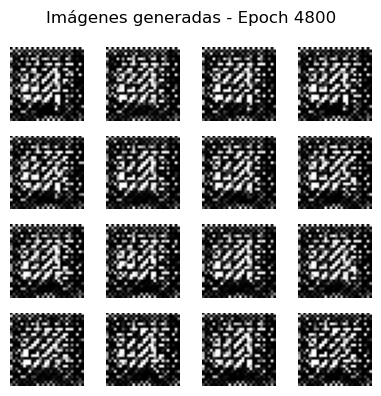

Epoch 4801
  D_real: 0.5739, D_fake: 0.5738, G: 1.7554
Epoch 4802
  D_real: 0.5738, D_fake: 0.5737, G: 1.7561
Epoch 4803
  D_real: 0.5737, D_fake: 0.5736, G: 1.7568
Epoch 4804
  D_real: 0.5736, D_fake: 0.5735, G: 1.7574
Epoch 4805
  D_real: 0.5735, D_fake: 0.5735, G: 1.7581
Epoch 4806
  D_real: 0.5734, D_fake: 0.5734, G: 1.7587
Epoch 4807
  D_real: 0.5734, D_fake: 0.5733, G: 1.7593
Epoch 4808
  D_real: 0.5733, D_fake: 0.5732, G: 1.7599
Epoch 4809
  D_real: 0.5732, D_fake: 0.5731, G: 1.7608
Epoch 4810
  D_real: 0.5731, D_fake: 0.5730, G: 1.7614
Epoch 4811
  D_real: 0.5730, D_fake: 0.5730, G: 1.7620
Epoch 4812
  D_real: 0.5729, D_fake: 0.5729, G: 1.7626
Epoch 4813
  D_real: 0.5729, D_fake: 0.5728, G: 1.7633
Epoch 4814
  D_real: 0.5728, D_fake: 0.5727, G: 1.7638
Epoch 4815
  D_real: 0.5727, D_fake: 0.5726, G: 1.7644
Epoch 4816
  D_real: 0.5726, D_fake: 0.5725, G: 1.7649
Epoch 4817
  D_real: 0.5725, D_fake: 0.5725, G: 1.7654
Epoch 4818
  D_real: 0.5724, D_fake: 0.5724, G: 1.7660
Epoch 4819

2025-04-24 19:24:38.520312: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


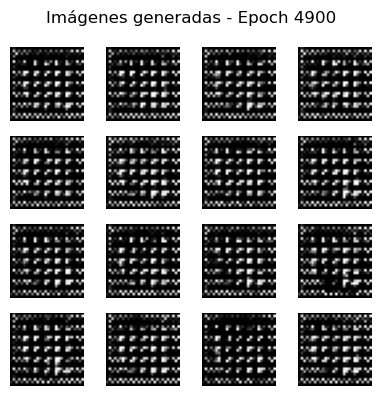

Epoch 4901
  D_real: 0.5658, D_fake: 0.5657, G: 1.8066
Epoch 4902
  D_real: 0.5657, D_fake: 0.5656, G: 1.8078
Epoch 4903
  D_real: 0.5656, D_fake: 0.5655, G: 1.8087
Epoch 4904
  D_real: 0.5655, D_fake: 0.5655, G: 1.8099
Epoch 4905
  D_real: 0.5654, D_fake: 0.5654, G: 1.8109
Epoch 4906
  D_real: 0.5654, D_fake: 0.5653, G: 1.8119
Epoch 4907
  D_real: 0.5653, D_fake: 0.5652, G: 1.8128
Epoch 4908
  D_real: 0.5652, D_fake: 0.5651, G: 1.8137
Epoch 4909
  D_real: 0.5651, D_fake: 0.5651, G: 1.8146
Epoch 4910
  D_real: 0.5650, D_fake: 0.5650, G: 1.8155
Epoch 4911
  D_real: 0.5650, D_fake: 0.5649, G: 1.8165
Epoch 4912
  D_real: 0.5649, D_fake: 0.5648, G: 1.8173
Epoch 4913
  D_real: 0.5648, D_fake: 0.5647, G: 1.8184
Epoch 4914
  D_real: 0.5647, D_fake: 0.5647, G: 1.8191
Epoch 4915
  D_real: 0.5646, D_fake: 0.5646, G: 1.8203
Epoch 4916
  D_real: 0.5646, D_fake: 0.5645, G: 1.8210
Epoch 4917
  D_real: 0.5645, D_fake: 0.5644, G: 1.8219
Epoch 4918
  D_real: 0.5644, D_fake: 0.5643, G: 1.8227
Epoch 4919

2025-04-24 19:24:52.259631: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


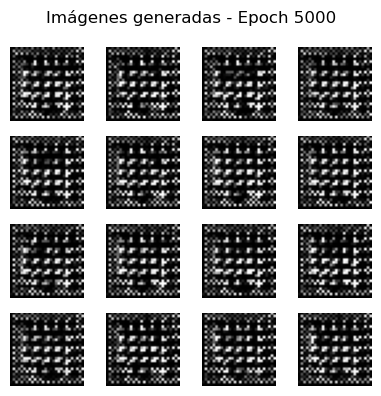

'\nEpoch 1000\n  D_real: 0.7195, D_fake: 0.7194, G: 1.0679\n'

In [12]:
# Entrenamos 5000 epocs
entrenar_gan(5000)
"""
Epoch 1000
  D_real: 0.7195, D_fake: 0.7194, G: 1.0679
"""

# Significado de cada métrica
## 1. D_real (Discriminador real)
Este valor mide cuán bien el discriminador puede distinguir entre las **imágenes reales** (las que provienen del conjunto de entrenamiento) y las **falsas** (las generadas por el generador).

- **D_real alto**: El discriminador está haciendo bien su trabajo, ya que está clasificando correctamente las imágenes reales como reales. Esto indica que el discriminador **no está siendo engañado fácilmente** por imágenes reales.
  
- **D_real bajo**: El discriminador tiene dificultades para distinguir las imágenes reales, es decir, está **fallando en su tarea**. Este comportamiento es inusual en un entrenamiento bien equilibrado, ya que implica que el discriminador no está aprendiendo correctamente.

## 2. D_fake (Discriminador falso)
Este valor mide cuán bien el discriminador puede identificar las **imágenes generadas** (las falsas) como tales.

- **D_fake alto**: El discriminador es capaz de identificar correctamente las imágenes generadas como falsas. Esto significa que el discriminador **está funcionando bien**, ya que está identificando las imágenes falsas del generador correctamente.

- **D_fake bajo**: Si este valor es bajo, el discriminador está siendo **engañado por el generador**, porque está clasificando las imágenes generadas como reales. Esto es bueno para el generador porque significa que está mejorando y generando imágenes más realistas.

## 3. G (Generador)
El valor **G** mide la calidad general del **generador**. Cuanto más alto sea, mejor será la capacidad del generador para crear imágenes realistas que engañen al discriminador.

- **G alto**: Un valor alto de G indica que el generador está haciendo un **muy buen trabajo** creando imágenes que son casi indistinguibles de las reales. Esto es lo que queremos en un GAN, ya que su objetivo es generar imágenes que engañen al discriminador.

- **G bajo**: Un valor bajo de G significa que el generador está **fallando** en producir imágenes de calidad, que son fácilmente detectadas como falsas por el discriminador.

# Riesgo del modo colapso de un modelo GAN
Se produce cuando un GAN empieza a producir siempo lo mismo o muy poca variedad de imágenes, aunque las entradas de ruido sean diferentes.

Se produce porque el genador descubre una trampa en el entrenamiento:

* Encuentra una imagen (o patrón) que el discriminador acepta como "real", empieza a repetir esa misma imagen porque funciona.

* El discriminador no es lo bastante fuerte para decir: "oye, esto ya lo vi".

* El modelo colapsa en un solo modo de salida.

# ¿Cómo seleccionar la mejor época?
La mejor época puede depender de varios factores, pero en general se busca:

* Discriminador balanceado -> D_real y D_fake cerca de 0.5
* Buen generador -> G alto (entre 1 y 2, o más si es estable)
* Discriminador no dominante -> D_fake no demasiado bajo
* Generador aprendiendo bien -> G subiendo, imágenes de buena calidad



Analizando los resultados visualmente cada 100 épocas, vemos que en la 4000 tenemos los mejores resultados, están todos los dígitos formados perfectamente, vamos a elegir esa época para el siguiente modelo.

In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

def entrenar_gan_guardar(N_ITS, ruta_generador_guardado):
    x_train = cargar_datos()
    generador = crear_generador()
    discriminador = crear_discriminador()
    gan = crear_GAN(generador, discriminador)

    TAM_LOTE = 64

    for i in range(1, N_ITS + 1):
        print(f"Epoch {i}")

        ruido = np.random.normal(0, 1, (TAM_LOTE, TAM_ENTRADA))
        imagenes_falsas = generador.predict(ruido, verbose=0)
        idx = np.random.randint(0, x_train.shape[0], TAM_LOTE)
        imagenes_reales = x_train[idx]

        reales = np.ones(TAM_LOTE) * 0.9
        falsas = np.zeros(TAM_LOTE)

        discriminador.trainable = True
        d_loss_real = discriminador.train_on_batch(imagenes_reales, reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_falsas, falsas)

        discriminador.trainable = False
        g_loss = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

        print(f"  D_real: {d_loss_real:.4f}, D_fake: {d_loss_fake:.4f}, G: {g_loss:.4f}")

        if i == 1 or i % 100 == 0:
            graficar_imagenes_generadas(i, generador)

    # Guardar el generador entrenado en un archivo
    generador.save(ruta_generador_guardado)
    print(f"Modelo generador guardado en {ruta_generador_guardado}")

In [14]:
# VOlvemos a establecer los valores de los optimizadores
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)
opt_gan = Adam(learning_rate=0.0002, beta_1=0.5)


In [15]:
# Establecer semillas para reproducibilidad
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

Cargando dígitos "4" desde MNIST...¡Listo!
Epoch 1
  D_real: 0.5695, D_fake: 0.6449, G: 0.6339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


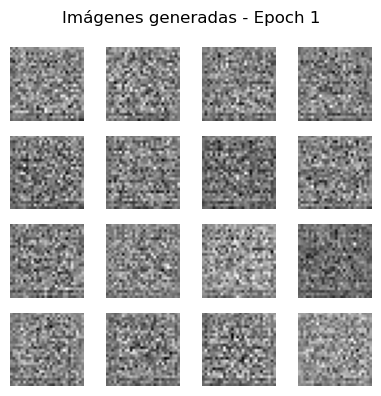

Epoch 2
  D_real: 0.5749, D_fake: 0.6625, G: 0.5206
Epoch 3
  D_real: 0.6058, D_fake: 0.6832, G: 0.4546
Epoch 4
  D_real: 0.6387, D_fake: 0.7078, G: 0.4396
Epoch 5
  D_real: 0.6708, D_fake: 0.7112, G: 0.4910
Epoch 6
  D_real: 0.6818, D_fake: 0.6925, G: 0.5257
Epoch 7
  D_real: 0.6741, D_fake: 0.6833, G: 0.5648
Epoch 8
  D_real: 0.6653, D_fake: 0.6746, G: 0.6051
Epoch 9
  D_real: 0.6582, D_fake: 0.6489, G: 0.6389
Epoch 10
  D_real: 0.6374, D_fake: 0.6287, G: 0.6942
Epoch 11
  D_real: 0.6185, D_fake: 0.6129, G: 0.7510
Epoch 12
  D_real: 0.6055, D_fake: 0.5931, G: 0.7853
Epoch 13
  D_real: 0.5856, D_fake: 0.5777, G: 0.8125
Epoch 14
  D_real: 0.5728, D_fake: 0.5639, G: 0.8460
Epoch 15
  D_real: 0.5584, D_fake: 0.5497, G: 0.8862
Epoch 16
  D_real: 0.5449, D_fake: 0.5373, G: 0.9274
Epoch 17
  D_real: 0.5341, D_fake: 0.5262, G: 0.9708
Epoch 18
  D_real: 0.5231, D_fake: 0.5165, G: 1.0004
Epoch 19
  D_real: 0.5137, D_fake: 0.5064, G: 1.0431
Epoch 20
  D_real: 0.5046, D_fake: 0.4982, G: 1.0728
E

2025-04-24 19:25:06.602202: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


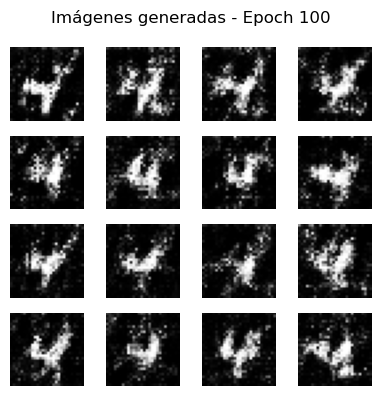

Epoch 101
  D_real: 0.5672, D_fake: 0.5682, G: 1.4521
Epoch 102
  D_real: 0.5706, D_fake: 0.5711, G: 1.4491
Epoch 103
  D_real: 0.5741, D_fake: 0.5744, G: 1.4472
Epoch 104
  D_real: 0.5759, D_fake: 0.5763, G: 1.4449
Epoch 105
  D_real: 0.5780, D_fake: 0.5777, G: 1.4439
Epoch 106
  D_real: 0.5794, D_fake: 0.5790, G: 1.4411
Epoch 107
  D_real: 0.5805, D_fake: 0.5813, G: 1.4379
Epoch 108
  D_real: 0.5824, D_fake: 0.5826, G: 1.4351
Epoch 109
  D_real: 0.5841, D_fake: 0.5847, G: 1.4328
Epoch 110
  D_real: 0.5863, D_fake: 0.5861, G: 1.4315
Epoch 111
  D_real: 0.5875, D_fake: 0.5882, G: 1.4295
Epoch 112
  D_real: 0.5899, D_fake: 0.5896, G: 1.4289
Epoch 113
  D_real: 0.5913, D_fake: 0.5909, G: 1.4292
Epoch 114
  D_real: 0.5922, D_fake: 0.5915, G: 1.4287
Epoch 115
  D_real: 0.5925, D_fake: 0.5926, G: 1.4265
Epoch 116
  D_real: 0.5937, D_fake: 0.5933, G: 1.4246
Epoch 117
  D_real: 0.5941, D_fake: 0.5947, G: 1.4215
Epoch 118
  D_real: 0.5957, D_fake: 0.5956, G: 1.4184
Epoch 119
  D_real: 0.5974, 

2025-04-24 19:25:19.854466: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


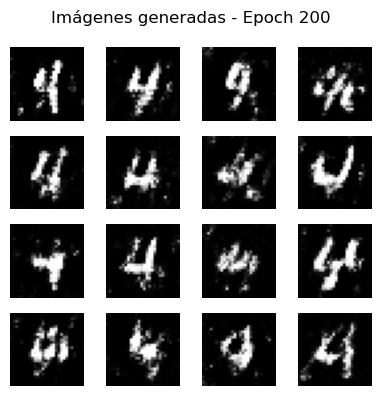

Epoch 201
  D_real: 0.6712, D_fake: 0.6712, G: 1.2837
Epoch 202
  D_real: 0.6718, D_fake: 0.6720, G: 1.2823
Epoch 203
  D_real: 0.6725, D_fake: 0.6725, G: 1.2811
Epoch 204
  D_real: 0.6731, D_fake: 0.6731, G: 1.2797
Epoch 205
  D_real: 0.6735, D_fake: 0.6734, G: 1.2784
Epoch 206
  D_real: 0.6740, D_fake: 0.6739, G: 1.2778
Epoch 207
  D_real: 0.6740, D_fake: 0.6738, G: 1.2769
Epoch 208
  D_real: 0.6743, D_fake: 0.6741, G: 1.2760
Epoch 209
  D_real: 0.6746, D_fake: 0.6746, G: 1.2750
Epoch 210
  D_real: 0.6751, D_fake: 0.6749, G: 1.2742
Epoch 211
  D_real: 0.6757, D_fake: 0.6757, G: 1.2724
Epoch 212
  D_real: 0.6760, D_fake: 0.6761, G: 1.2707
Epoch 213
  D_real: 0.6764, D_fake: 0.6765, G: 1.2693
Epoch 214
  D_real: 0.6773, D_fake: 0.6778, G: 1.2682
Epoch 215
  D_real: 0.6785, D_fake: 0.6781, G: 1.2671
Epoch 216
  D_real: 0.6787, D_fake: 0.6788, G: 1.2658
Epoch 217
  D_real: 0.6793, D_fake: 0.6793, G: 1.2650
Epoch 218
  D_real: 0.6797, D_fake: 0.6796, G: 1.2641
Epoch 219
  D_real: 0.6801, 

2025-04-24 19:25:32.522023: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


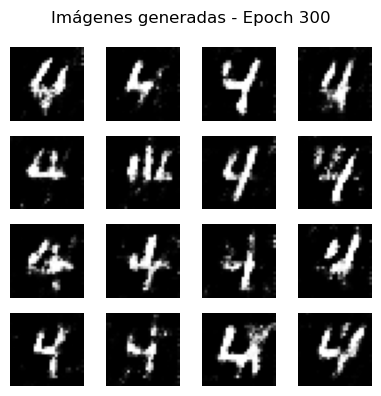

Epoch 301
  D_real: 0.7067, D_fake: 0.7065, G: 1.1957
Epoch 302
  D_real: 0.7067, D_fake: 0.7066, G: 1.1949
Epoch 303
  D_real: 0.7067, D_fake: 0.7066, G: 1.1940
Epoch 304
  D_real: 0.7069, D_fake: 0.7070, G: 1.1930
Epoch 305
  D_real: 0.7073, D_fake: 0.7072, G: 1.1923
Epoch 306
  D_real: 0.7075, D_fake: 0.7075, G: 1.1918
Epoch 307
  D_real: 0.7077, D_fake: 0.7077, G: 1.1912
Epoch 308
  D_real: 0.7080, D_fake: 0.7081, G: 1.1908
Epoch 309
  D_real: 0.7083, D_fake: 0.7082, G: 1.1902
Epoch 310
  D_real: 0.7085, D_fake: 0.7084, G: 1.1896
Epoch 311
  D_real: 0.7086, D_fake: 0.7088, G: 1.1888
Epoch 312
  D_real: 0.7090, D_fake: 0.7091, G: 1.1884
Epoch 313
  D_real: 0.7094, D_fake: 0.7092, G: 1.1877
Epoch 314
  D_real: 0.7094, D_fake: 0.7092, G: 1.1874
Epoch 315
  D_real: 0.7096, D_fake: 0.7095, G: 1.1873
Epoch 316
  D_real: 0.7095, D_fake: 0.7094, G: 1.1867
Epoch 317
  D_real: 0.7097, D_fake: 0.7095, G: 1.1863
Epoch 318
  D_real: 0.7098, D_fake: 0.7096, G: 1.1858
Epoch 319
  D_real: 0.7099, 

2025-04-24 19:25:45.185992: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


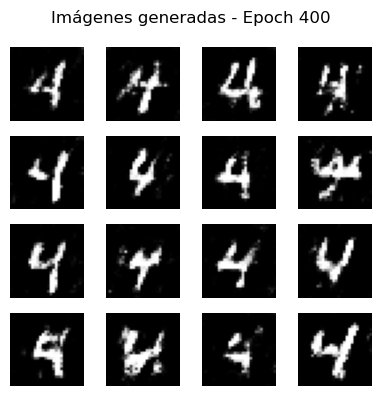

Epoch 401
  D_real: 0.7198, D_fake: 0.7197, G: 1.1491
Epoch 402
  D_real: 0.7199, D_fake: 0.7197, G: 1.1489
Epoch 403
  D_real: 0.7199, D_fake: 0.7197, G: 1.1487
Epoch 404
  D_real: 0.7199, D_fake: 0.7197, G: 1.1481
Epoch 405
  D_real: 0.7198, D_fake: 0.7199, G: 1.1477
Epoch 406
  D_real: 0.7200, D_fake: 0.7202, G: 1.1472
Epoch 407
  D_real: 0.7203, D_fake: 0.7202, G: 1.1469
Epoch 408
  D_real: 0.7202, D_fake: 0.7201, G: 1.1469
Epoch 409
  D_real: 0.7203, D_fake: 0.7201, G: 1.1465
Epoch 410
  D_real: 0.7203, D_fake: 0.7201, G: 1.1463
Epoch 411
  D_real: 0.7203, D_fake: 0.7202, G: 1.1461
Epoch 412
  D_real: 0.7203, D_fake: 0.7202, G: 1.1458
Epoch 413
  D_real: 0.7203, D_fake: 0.7202, G: 1.1453
Epoch 414
  D_real: 0.7204, D_fake: 0.7203, G: 1.1451
Epoch 415
  D_real: 0.7206, D_fake: 0.7204, G: 1.1448
Epoch 416
  D_real: 0.7207, D_fake: 0.7206, G: 1.1447
Epoch 417
  D_real: 0.7208, D_fake: 0.7207, G: 1.1445
Epoch 418
  D_real: 0.7208, D_fake: 0.7207, G: 1.1443
Epoch 419
  D_real: 0.7207, 

2025-04-24 19:25:58.168922: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


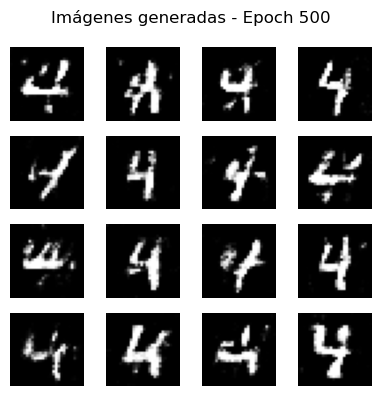

Epoch 501
  D_real: 0.7245, D_fake: 0.7244, G: 1.1199
Epoch 502
  D_real: 0.7244, D_fake: 0.7242, G: 1.1199
Epoch 503
  D_real: 0.7243, D_fake: 0.7241, G: 1.1197
Epoch 504
  D_real: 0.7242, D_fake: 0.7241, G: 1.1194
Epoch 505
  D_real: 0.7242, D_fake: 0.7240, G: 1.1191
Epoch 506
  D_real: 0.7241, D_fake: 0.7241, G: 1.1189
Epoch 507
  D_real: 0.7242, D_fake: 0.7241, G: 1.1185
Epoch 508
  D_real: 0.7241, D_fake: 0.7241, G: 1.1182
Epoch 509
  D_real: 0.7242, D_fake: 0.7241, G: 1.1177
Epoch 510
  D_real: 0.7243, D_fake: 0.7243, G: 1.1174
Epoch 511
  D_real: 0.7244, D_fake: 0.7243, G: 1.1171
Epoch 512
  D_real: 0.7244, D_fake: 0.7243, G: 1.1170
Epoch 513
  D_real: 0.7244, D_fake: 0.7243, G: 1.1167
Epoch 514
  D_real: 0.7244, D_fake: 0.7243, G: 1.1165
Epoch 515
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 516
  D_real: 0.7244, D_fake: 0.7242, G: 1.1165
Epoch 517
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 518
  D_real: 0.7243, D_fake: 0.7241, G: 1.1165
Epoch 519
  D_real: 0.7241, 

2025-04-24 19:26:11.390028: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


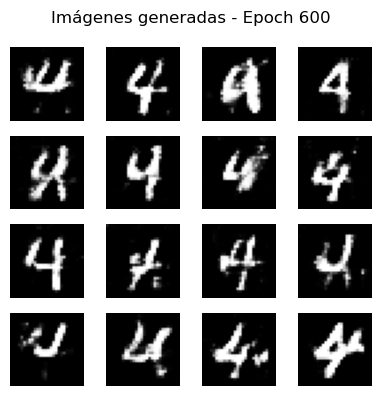

Epoch 601
  D_real: 0.7252, D_fake: 0.7251, G: 1.1007
Epoch 602
  D_real: 0.7252, D_fake: 0.7250, G: 1.1005
Epoch 603
  D_real: 0.7252, D_fake: 0.7251, G: 1.1004
Epoch 604
  D_real: 0.7252, D_fake: 0.7251, G: 1.1003
Epoch 605
  D_real: 0.7252, D_fake: 0.7250, G: 1.1001
Epoch 606
  D_real: 0.7251, D_fake: 0.7250, G: 1.1000
Epoch 607
  D_real: 0.7251, D_fake: 0.7249, G: 1.1001
Epoch 608
  D_real: 0.7250, D_fake: 0.7249, G: 1.0999
Epoch 609
  D_real: 0.7250, D_fake: 0.7249, G: 1.0998
Epoch 610
  D_real: 0.7249, D_fake: 0.7249, G: 1.0998
Epoch 611
  D_real: 0.7248, D_fake: 0.7248, G: 1.0997
Epoch 612
  D_real: 0.7249, D_fake: 0.7248, G: 1.0997
Epoch 613
  D_real: 0.7249, D_fake: 0.7248, G: 1.0998
Epoch 614
  D_real: 0.7248, D_fake: 0.7248, G: 1.0995
Epoch 615
  D_real: 0.7248, D_fake: 0.7247, G: 1.0991
Epoch 616
  D_real: 0.7248, D_fake: 0.7248, G: 1.0989
Epoch 617
  D_real: 0.7249, D_fake: 0.7248, G: 1.0988
Epoch 618
  D_real: 0.7249, D_fake: 0.7249, G: 1.0986
Epoch 619
  D_real: 0.7251, 

2025-04-24 19:26:24.597484: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


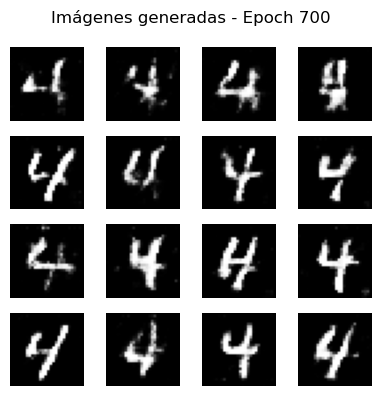

Epoch 701
  D_real: 0.7248, D_fake: 0.7246, G: 1.0880
Epoch 702
  D_real: 0.7247, D_fake: 0.7245, G: 1.0880
Epoch 703
  D_real: 0.7245, D_fake: 0.7243, G: 1.0879
Epoch 704
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 705
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 706
  D_real: 0.7244, D_fake: 0.7242, G: 1.0877
Epoch 707
  D_real: 0.7242, D_fake: 0.7242, G: 1.0876
Epoch 708
  D_real: 0.7243, D_fake: 0.7242, G: 1.0874
Epoch 709
  D_real: 0.7243, D_fake: 0.7242, G: 1.0872
Epoch 710
  D_real: 0.7243, D_fake: 0.7242, G: 1.0871
Epoch 711
  D_real: 0.7242, D_fake: 0.7242, G: 1.0869
Epoch 712
  D_real: 0.7243, D_fake: 0.7242, G: 1.0866
Epoch 713
  D_real: 0.7242, D_fake: 0.7241, G: 1.0865
Epoch 714
  D_real: 0.7242, D_fake: 0.7242, G: 1.0866
Epoch 715
  D_real: 0.7244, D_fake: 0.7242, G: 1.0867
Epoch 716
  D_real: 0.7243, D_fake: 0.7242, G: 1.0868
Epoch 717
  D_real: 0.7242, D_fake: 0.7241, G: 1.0869
Epoch 718
  D_real: 0.7241, D_fake: 0.7240, G: 1.0869
Epoch 719
  D_real: 0.7240, 

2025-04-24 19:26:38.148103: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


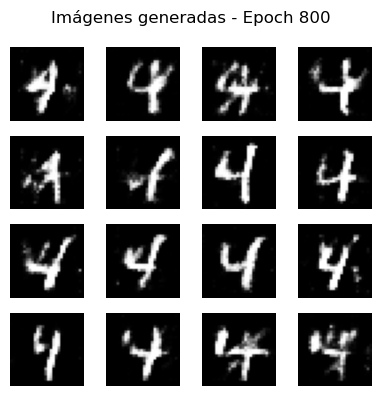

Epoch 801
  D_real: 0.7230, D_fake: 0.7230, G: 1.0794
Epoch 802
  D_real: 0.7231, D_fake: 0.7230, G: 1.0793
Epoch 803
  D_real: 0.7230, D_fake: 0.7230, G: 1.0792
Epoch 804
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 805
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 806
  D_real: 0.7229, D_fake: 0.7228, G: 1.0792
Epoch 807
  D_real: 0.7229, D_fake: 0.7227, G: 1.0791
Epoch 808
  D_real: 0.7228, D_fake: 0.7227, G: 1.0790
Epoch 809
  D_real: 0.7226, D_fake: 0.7226, G: 1.0788
Epoch 810
  D_real: 0.7227, D_fake: 0.7226, G: 1.0788
Epoch 811
  D_real: 0.7227, D_fake: 0.7226, G: 1.0787
Epoch 812
  D_real: 0.7226, D_fake: 0.7226, G: 1.0787
Epoch 813
  D_real: 0.7227, D_fake: 0.7227, G: 1.0786
Epoch 814
  D_real: 0.7228, D_fake: 0.7227, G: 1.0785
Epoch 815
  D_real: 0.7228, D_fake: 0.7226, G: 1.0785
Epoch 816
  D_real: 0.7226, D_fake: 0.7225, G: 1.0784
Epoch 817
  D_real: 0.7226, D_fake: 0.7225, G: 1.0783
Epoch 818
  D_real: 0.7224, D_fake: 0.7224, G: 1.0783
Epoch 819
  D_real: 0.7224, 

2025-04-24 19:26:51.289395: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


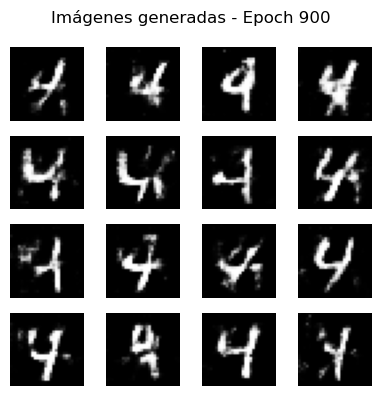

Epoch 901
  D_real: 0.7212, D_fake: 0.7211, G: 1.0732
Epoch 902
  D_real: 0.7211, D_fake: 0.7209, G: 1.0733
Epoch 903
  D_real: 0.7209, D_fake: 0.7208, G: 1.0732
Epoch 904
  D_real: 0.7208, D_fake: 0.7208, G: 1.0731
Epoch 905
  D_real: 0.7208, D_fake: 0.7208, G: 1.0730
Epoch 906
  D_real: 0.7208, D_fake: 0.7208, G: 1.0729
Epoch 907
  D_real: 0.7209, D_fake: 0.7209, G: 1.0727
Epoch 908
  D_real: 0.7209, D_fake: 0.7209, G: 1.0725
Epoch 909
  D_real: 0.7210, D_fake: 0.7209, G: 1.0723
Epoch 910
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 911
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 912
  D_real: 0.7211, D_fake: 0.7209, G: 1.0723
Epoch 913
  D_real: 0.7210, D_fake: 0.7208, G: 1.0721
Epoch 914
  D_real: 0.7209, D_fake: 0.7208, G: 1.0720
Epoch 915
  D_real: 0.7208, D_fake: 0.7209, G: 1.0720
Epoch 916
  D_real: 0.7210, D_fake: 0.7211, G: 1.0719
Epoch 917
  D_real: 0.7212, D_fake: 0.7211, G: 1.0718
Epoch 918
  D_real: 0.7213, D_fake: 0.7212, G: 1.0718
Epoch 919
  D_real: 0.7212, 

2025-04-24 19:27:03.911281: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


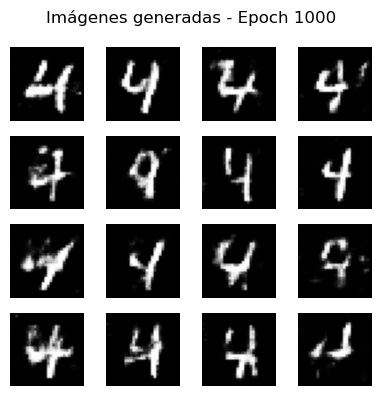

Epoch 1001
  D_real: 0.7195, D_fake: 0.7194, G: 1.0680
Epoch 1002
  D_real: 0.7194, D_fake: 0.7193, G: 1.0680
Epoch 1003
  D_real: 0.7193, D_fake: 0.7192, G: 1.0679
Epoch 1004
  D_real: 0.7192, D_fake: 0.7192, G: 1.0677
Epoch 1005
  D_real: 0.7192, D_fake: 0.7193, G: 1.0675
Epoch 1006
  D_real: 0.7194, D_fake: 0.7195, G: 1.0674
Epoch 1007
  D_real: 0.7195, D_fake: 0.7195, G: 1.0673
Epoch 1008
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1009
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1010
  D_real: 0.7195, D_fake: 0.7195, G: 1.0671
Epoch 1011
  D_real: 0.7195, D_fake: 0.7193, G: 1.0673
Epoch 1012
  D_real: 0.7193, D_fake: 0.7191, G: 1.0676
Epoch 1013
  D_real: 0.7192, D_fake: 0.7190, G: 1.0677
Epoch 1014
  D_real: 0.7189, D_fake: 0.7188, G: 1.0678
Epoch 1015
  D_real: 0.7188, D_fake: 0.7187, G: 1.0677
Epoch 1016
  D_real: 0.7187, D_fake: 0.7186, G: 1.0677
Epoch 1017
  D_real: 0.7187, D_fake: 0.7187, G: 1.0675
Epoch 1018
  D_real: 0.7187, D_fake: 0.7187, G: 1.0674
Epoch 1019

2025-04-24 19:27:17.412546: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


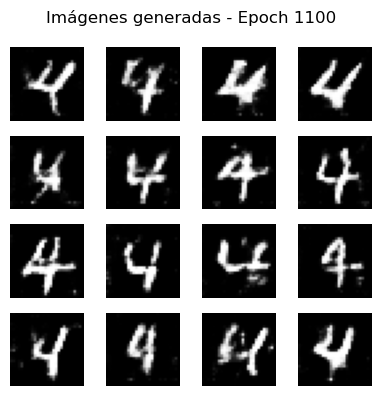

Epoch 1101
  D_real: 0.7166, D_fake: 0.7166, G: 1.0646
Epoch 1102
  D_real: 0.7166, D_fake: 0.7166, G: 1.0644
Epoch 1103
  D_real: 0.7166, D_fake: 0.7166, G: 1.0643
Epoch 1104
  D_real: 0.7167, D_fake: 0.7166, G: 1.0643
Epoch 1105
  D_real: 0.7166, D_fake: 0.7165, G: 1.0643
Epoch 1106
  D_real: 0.7165, D_fake: 0.7164, G: 1.0642
Epoch 1107
  D_real: 0.7164, D_fake: 0.7164, G: 1.0641
Epoch 1108
  D_real: 0.7164, D_fake: 0.7163, G: 1.0641
Epoch 1109
  D_real: 0.7164, D_fake: 0.7162, G: 1.0641
Epoch 1110
  D_real: 0.7162, D_fake: 0.7162, G: 1.0641
Epoch 1111
  D_real: 0.7162, D_fake: 0.7161, G: 1.0641
Epoch 1112
  D_real: 0.7161, D_fake: 0.7161, G: 1.0640
Epoch 1113
  D_real: 0.7161, D_fake: 0.7160, G: 1.0639
Epoch 1114
  D_real: 0.7161, D_fake: 0.7160, G: 1.0638
Epoch 1115
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1116
  D_real: 0.7160, D_fake: 0.7159, G: 1.0638
Epoch 1117
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1118
  D_real: 0.7159, D_fake: 0.7158, G: 1.0639
Epoch 1119

2025-04-24 19:27:30.782039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


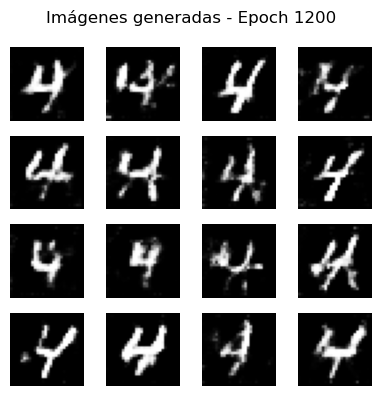

Epoch 1201
  D_real: 0.7149, D_fake: 0.7148, G: 1.0595
Epoch 1202
  D_real: 0.7149, D_fake: 0.7148, G: 1.0596
Epoch 1203
  D_real: 0.7148, D_fake: 0.7146, G: 1.0597
Epoch 1204
  D_real: 0.7147, D_fake: 0.7145, G: 1.0599
Epoch 1205
  D_real: 0.7145, D_fake: 0.7145, G: 1.0598
Epoch 1206
  D_real: 0.7145, D_fake: 0.7145, G: 1.0597
Epoch 1207
  D_real: 0.7145, D_fake: 0.7146, G: 1.0595
Epoch 1208
  D_real: 0.7146, D_fake: 0.7147, G: 1.0594
Epoch 1209
  D_real: 0.7147, D_fake: 0.7147, G: 1.0593
Epoch 1210
  D_real: 0.7148, D_fake: 0.7147, G: 1.0593
Epoch 1211
  D_real: 0.7147, D_fake: 0.7146, G: 1.0593
Epoch 1212
  D_real: 0.7147, D_fake: 0.7146, G: 1.0594
Epoch 1213
  D_real: 0.7146, D_fake: 0.7145, G: 1.0595
Epoch 1214
  D_real: 0.7146, D_fake: 0.7144, G: 1.0597
Epoch 1215
  D_real: 0.7144, D_fake: 0.7143, G: 1.0596
Epoch 1216
  D_real: 0.7143, D_fake: 0.7143, G: 1.0595
Epoch 1217
  D_real: 0.7143, D_fake: 0.7142, G: 1.0594
Epoch 1218
  D_real: 0.7142, D_fake: 0.7141, G: 1.0593
Epoch 1219

2025-04-24 19:27:43.938944: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


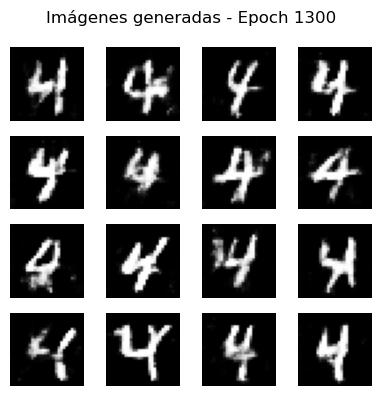

Epoch 1301
  D_real: 0.7116, D_fake: 0.7116, G: 1.0563
Epoch 1302
  D_real: 0.7117, D_fake: 0.7117, G: 1.0562
Epoch 1303
  D_real: 0.7118, D_fake: 0.7119, G: 1.0560
Epoch 1304
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1305
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1306
  D_real: 0.7120, D_fake: 0.7119, G: 1.0560
Epoch 1307
  D_real: 0.7119, D_fake: 0.7120, G: 1.0559
Epoch 1308
  D_real: 0.7120, D_fake: 0.7119, G: 1.0558
Epoch 1309
  D_real: 0.7120, D_fake: 0.7119, G: 1.0559
Epoch 1310
  D_real: 0.7119, D_fake: 0.7118, G: 1.0559
Epoch 1311
  D_real: 0.7118, D_fake: 0.7117, G: 1.0559
Epoch 1312
  D_real: 0.7117, D_fake: 0.7116, G: 1.0559
Epoch 1313
  D_real: 0.7116, D_fake: 0.7116, G: 1.0558
Epoch 1314
  D_real: 0.7116, D_fake: 0.7115, G: 1.0559
Epoch 1315
  D_real: 0.7115, D_fake: 0.7114, G: 1.0560
Epoch 1316
  D_real: 0.7114, D_fake: 0.7113, G: 1.0560
Epoch 1317
  D_real: 0.7113, D_fake: 0.7113, G: 1.0559
Epoch 1318
  D_real: 0.7113, D_fake: 0.7114, G: 1.0557
Epoch 1319

2025-04-24 19:27:57.155714: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


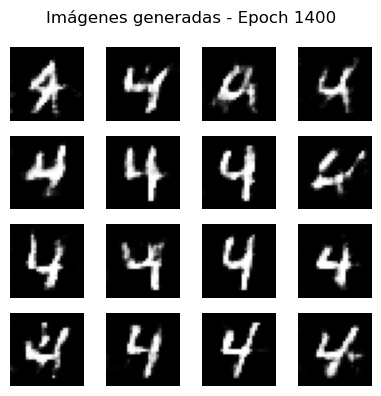

Epoch 1401
  D_real: 0.7100, D_fake: 0.7099, G: 1.0538
Epoch 1402
  D_real: 0.7099, D_fake: 0.7098, G: 1.0538
Epoch 1403
  D_real: 0.7098, D_fake: 0.7097, G: 1.0537
Epoch 1404
  D_real: 0.7097, D_fake: 0.7097, G: 1.0536
Epoch 1405
  D_real: 0.7097, D_fake: 0.7097, G: 1.0535
Epoch 1406
  D_real: 0.7097, D_fake: 0.7097, G: 1.0533
Epoch 1407
  D_real: 0.7098, D_fake: 0.7099, G: 1.0531
Epoch 1408
  D_real: 0.7100, D_fake: 0.7100, G: 1.0531
Epoch 1409
  D_real: 0.7100, D_fake: 0.7101, G: 1.0530
Epoch 1410
  D_real: 0.7102, D_fake: 0.7101, G: 1.0530
Epoch 1411
  D_real: 0.7102, D_fake: 0.7100, G: 1.0533
Epoch 1412
  D_real: 0.7100, D_fake: 0.7099, G: 1.0534
Epoch 1413
  D_real: 0.7099, D_fake: 0.7097, G: 1.0537
Epoch 1414
  D_real: 0.7096, D_fake: 0.7095, G: 1.0538
Epoch 1415
  D_real: 0.7095, D_fake: 0.7094, G: 1.0539
Epoch 1416
  D_real: 0.7093, D_fake: 0.7094, G: 1.0537
Epoch 1417
  D_real: 0.7094, D_fake: 0.7095, G: 1.0534
Epoch 1418
  D_real: 0.7095, D_fake: 0.7095, G: 1.0532
Epoch 1419

2025-04-24 19:28:10.552008: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


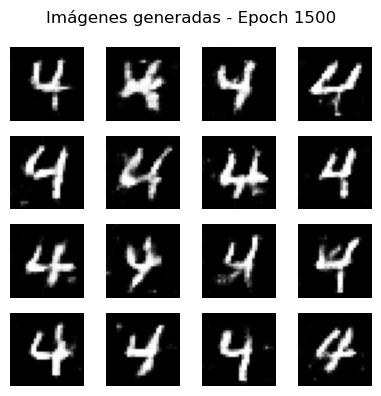

Epoch 1501
  D_real: 0.7068, D_fake: 0.7067, G: 1.0529
Epoch 1502
  D_real: 0.7067, D_fake: 0.7067, G: 1.0528
Epoch 1503
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1504
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1505
  D_real: 0.7067, D_fake: 0.7067, G: 1.0526
Epoch 1506
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1507
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1508
  D_real: 0.7066, D_fake: 0.7066, G: 1.0527
Epoch 1509
  D_real: 0.7066, D_fake: 0.7065, G: 1.0527
Epoch 1510
  D_real: 0.7065, D_fake: 0.7064, G: 1.0527
Epoch 1511
  D_real: 0.7064, D_fake: 0.7064, G: 1.0526
Epoch 1512
  D_real: 0.7063, D_fake: 0.7063, G: 1.0525
Epoch 1513
  D_real: 0.7064, D_fake: 0.7064, G: 1.0524
Epoch 1514
  D_real: 0.7064, D_fake: 0.7064, G: 1.0523
Epoch 1515
  D_real: 0.7065, D_fake: 0.7065, G: 1.0522
Epoch 1516
  D_real: 0.7065, D_fake: 0.7064, G: 1.0522
Epoch 1517
  D_real: 0.7065, D_fake: 0.7064, G: 1.0523
Epoch 1518
  D_real: 0.7064, D_fake: 0.7063, G: 1.0524
Epoch 1519

2025-04-24 19:28:23.437003: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


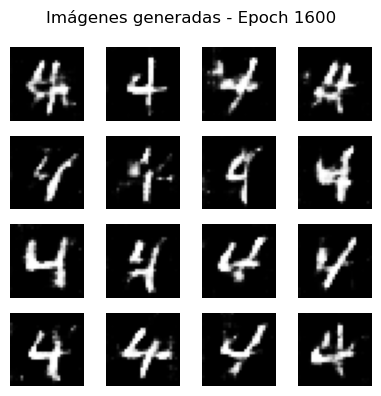

Epoch 1601
  D_real: 0.7031, D_fake: 0.7030, G: 1.0530
Epoch 1602
  D_real: 0.7030, D_fake: 0.7028, G: 1.0532
Epoch 1603
  D_real: 0.7028, D_fake: 0.7026, G: 1.0535
Epoch 1604
  D_real: 0.7026, D_fake: 0.7024, G: 1.0537
Epoch 1605
  D_real: 0.7024, D_fake: 0.7024, G: 1.0537
Epoch 1606
  D_real: 0.7023, D_fake: 0.7023, G: 1.0536
Epoch 1607
  D_real: 0.7023, D_fake: 0.7023, G: 1.0535
Epoch 1608
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1609
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1610
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1611
  D_real: 0.7022, D_fake: 0.7021, G: 1.0535
Epoch 1612
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1613
  D_real: 0.7022, D_fake: 0.7021, G: 1.0533
Epoch 1614
  D_real: 0.7022, D_fake: 0.7022, G: 1.0532
Epoch 1615
  D_real: 0.7022, D_fake: 0.7022, G: 1.0531
Epoch 1616
  D_real: 0.7022, D_fake: 0.7021, G: 1.0532
Epoch 1617
  D_real: 0.7021, D_fake: 0.7021, G: 1.0533
Epoch 1618
  D_real: 0.7021, D_fake: 0.7021, G: 1.0534
Epoch 1619

2025-04-24 19:28:36.173033: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


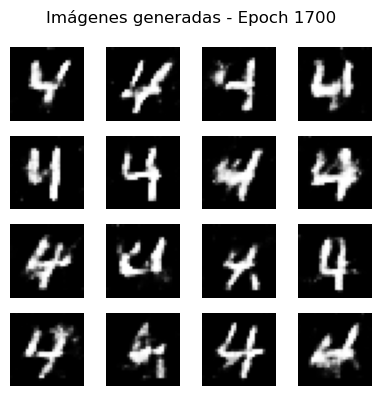

Epoch 1701
  D_real: 0.7003, D_fake: 0.7003, G: 1.0522
Epoch 1702
  D_real: 0.7003, D_fake: 0.7002, G: 1.0522
Epoch 1703
  D_real: 0.7002, D_fake: 0.7001, G: 1.0524
Epoch 1704
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1705
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1706
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1707
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1708
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1709
  D_real: 0.7001, D_fake: 0.7000, G: 1.0523
Epoch 1710
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1711
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1712
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1713
  D_real: 0.7001, D_fake: 0.7000, G: 1.0521
Epoch 1714
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1715
  D_real: 0.7001, D_fake: 0.7000, G: 1.0520
Epoch 1716
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1717
  D_real: 0.7000, D_fake: 0.6999, G: 1.0521
Epoch 1718
  D_real: 0.6999, D_fake: 0.6999, G: 1.0521
Epoch 1719

2025-04-24 19:28:49.001717: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


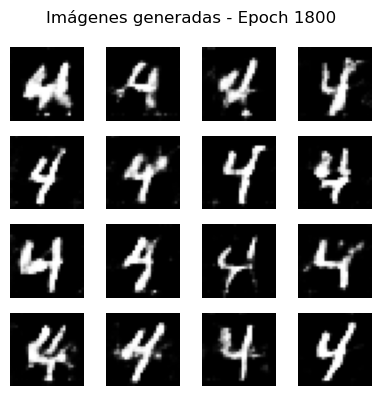

Epoch 1801
  D_real: 0.6981, D_fake: 0.6981, G: 1.0508
Epoch 1802
  D_real: 0.6981, D_fake: 0.6982, G: 1.0506
Epoch 1803
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1804
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1805
  D_real: 0.6983, D_fake: 0.6982, G: 1.0507
Epoch 1806
  D_real: 0.6982, D_fake: 0.6981, G: 1.0509
Epoch 1807
  D_real: 0.6981, D_fake: 0.6979, G: 1.0513
Epoch 1808
  D_real: 0.6979, D_fake: 0.6978, G: 1.0514
Epoch 1809
  D_real: 0.6978, D_fake: 0.6977, G: 1.0515
Epoch 1810
  D_real: 0.6977, D_fake: 0.6977, G: 1.0514
Epoch 1811
  D_real: 0.6976, D_fake: 0.6977, G: 1.0513
Epoch 1812
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1813
  D_real: 0.6977, D_fake: 0.6976, G: 1.0514
Epoch 1814
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1815
  D_real: 0.6976, D_fake: 0.6975, G: 1.0514
Epoch 1816
  D_real: 0.6975, D_fake: 0.6974, G: 1.0515
Epoch 1817
  D_real: 0.6974, D_fake: 0.6973, G: 1.0515
Epoch 1818
  D_real: 0.6973, D_fake: 0.6973, G: 1.0514
Epoch 1819

2025-04-24 19:29:01.911805: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


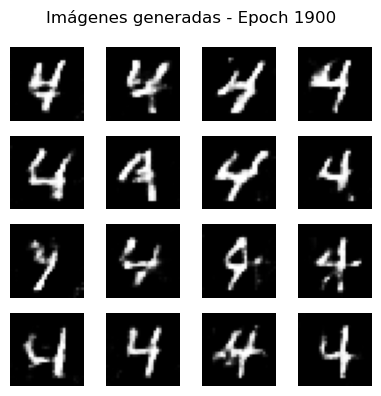

Epoch 1901
  D_real: 0.6953, D_fake: 0.6952, G: 1.0511
Epoch 1902
  D_real: 0.6952, D_fake: 0.6951, G: 1.0512
Epoch 1903
  D_real: 0.6950, D_fake: 0.6950, G: 1.0511
Epoch 1904
  D_real: 0.6949, D_fake: 0.6949, G: 1.0510
Epoch 1905
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1906
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1907
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1908
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1909
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1910
  D_real: 0.6950, D_fake: 0.6949, G: 1.0509
Epoch 1911
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1912
  D_real: 0.6949, D_fake: 0.6948, G: 1.0509
Epoch 1913
  D_real: 0.6948, D_fake: 0.6949, G: 1.0508
Epoch 1914
  D_real: 0.6949, D_fake: 0.6950, G: 1.0507
Epoch 1915
  D_real: 0.6950, D_fake: 0.6951, G: 1.0505
Epoch 1916
  D_real: 0.6952, D_fake: 0.6952, G: 1.0504
Epoch 1917
  D_real: 0.6953, D_fake: 0.6952, G: 1.0505
Epoch 1918
  D_real: 0.6953, D_fake: 0.6953, G: 1.0505
Epoch 1919

2025-04-24 19:29:14.697357: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


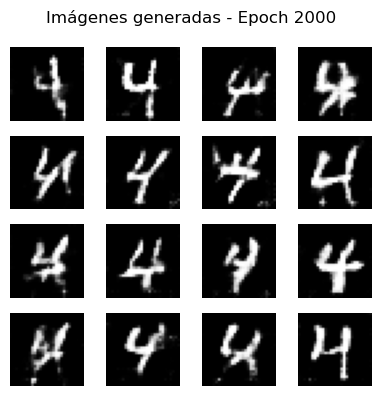

Epoch 2001
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2002
  D_real: 0.6929, D_fake: 0.6929, G: 1.0507
Epoch 2003
  D_real: 0.6930, D_fake: 0.6930, G: 1.0506
Epoch 2004
  D_real: 0.6931, D_fake: 0.6931, G: 1.0507
Epoch 2005
  D_real: 0.6931, D_fake: 0.6930, G: 1.0508
Epoch 2006
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2007
  D_real: 0.6930, D_fake: 0.6929, G: 1.0510
Epoch 2008
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2009
  D_real: 0.6928, D_fake: 0.6928, G: 1.0510
Epoch 2010
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2011
  D_real: 0.6928, D_fake: 0.6928, G: 1.0509
Epoch 2012
  D_real: 0.6928, D_fake: 0.6928, G: 1.0508
Epoch 2013
  D_real: 0.6928, D_fake: 0.6929, G: 1.0506
Epoch 2014
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2015
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2016
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2017
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2018
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2019

2025-04-24 19:29:27.206439: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


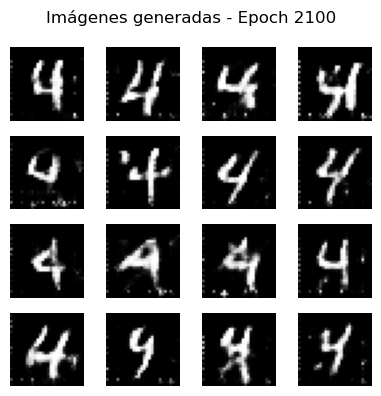

Epoch 2101
  D_real: 0.6873, D_fake: 0.6872, G: 1.0564
Epoch 2102
  D_real: 0.6872, D_fake: 0.6871, G: 1.0564
Epoch 2103
  D_real: 0.6871, D_fake: 0.6870, G: 1.0564
Epoch 2104
  D_real: 0.6870, D_fake: 0.6869, G: 1.0564
Epoch 2105
  D_real: 0.6869, D_fake: 0.6868, G: 1.0565
Epoch 2106
  D_real: 0.6868, D_fake: 0.6867, G: 1.0565
Epoch 2107
  D_real: 0.6867, D_fake: 0.6867, G: 1.0565
Epoch 2108
  D_real: 0.6867, D_fake: 0.6866, G: 1.0565
Epoch 2109
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2110
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2111
  D_real: 0.6866, D_fake: 0.6866, G: 1.0564
Epoch 2112
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2113
  D_real: 0.6865, D_fake: 0.6864, G: 1.0564
Epoch 2114
  D_real: 0.6865, D_fake: 0.6864, G: 1.0565
Epoch 2115
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2116
  D_real: 0.6864, D_fake: 0.6864, G: 1.0565
Epoch 2117
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2118
  D_real: 0.6863, D_fake: 0.6863, G: 1.0566
Epoch 2119

2025-04-24 19:29:40.105992: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


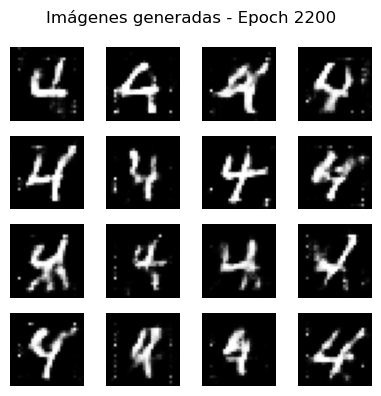

Epoch 2201
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2202
  D_real: 0.6835, D_fake: 0.6835, G: 1.0576
Epoch 2203
  D_real: 0.6836, D_fake: 0.6836, G: 1.0576
Epoch 2204
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2205
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2206
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2207
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2208
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2209
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2210
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2211
  D_real: 0.6835, D_fake: 0.6834, G: 1.0577
Epoch 2212
  D_real: 0.6833, D_fake: 0.6833, G: 1.0577
Epoch 2213
  D_real: 0.6833, D_fake: 0.6832, G: 1.0578
Epoch 2214
  D_real: 0.6832, D_fake: 0.6831, G: 1.0577
Epoch 2215
  D_real: 0.6831, D_fake: 0.6831, G: 1.0578
Epoch 2216
  D_real: 0.6831, D_fake: 0.6831, G: 1.0577
Epoch 2217
  D_real: 0.6831, D_fake: 0.6832, G: 1.0576
Epoch 2218
  D_real: 0.6832, D_fake: 0.6833, G: 1.0575
Epoch 2219

2025-04-24 19:29:53.659858: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


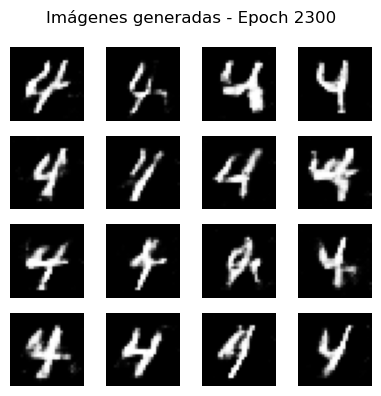

Epoch 2301
  D_real: 0.6814, D_fake: 0.6814, G: 1.0576
Epoch 2302
  D_real: 0.6814, D_fake: 0.6814, G: 1.0575
Epoch 2303
  D_real: 0.6814, D_fake: 0.6815, G: 1.0573
Epoch 2304
  D_real: 0.6815, D_fake: 0.6815, G: 1.0573
Epoch 2305
  D_real: 0.6816, D_fake: 0.6815, G: 1.0574
Epoch 2306
  D_real: 0.6815, D_fake: 0.6815, G: 1.0574
Epoch 2307
  D_real: 0.6815, D_fake: 0.6814, G: 1.0576
Epoch 2308
  D_real: 0.6814, D_fake: 0.6813, G: 1.0578
Epoch 2309
  D_real: 0.6813, D_fake: 0.6811, G: 1.0580
Epoch 2310
  D_real: 0.6811, D_fake: 0.6811, G: 1.0579
Epoch 2311
  D_real: 0.6811, D_fake: 0.6812, G: 1.0578
Epoch 2312
  D_real: 0.6811, D_fake: 0.6812, G: 1.0577
Epoch 2313
  D_real: 0.6812, D_fake: 0.6813, G: 1.0576
Epoch 2314
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2315
  D_real: 0.6813, D_fake: 0.6813, G: 1.0576
Epoch 2316
  D_real: 0.6814, D_fake: 0.6813, G: 1.0576
Epoch 2317
  D_real: 0.6813, D_fake: 0.6813, G: 1.0577
Epoch 2318
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2319

2025-04-24 19:30:06.335602: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


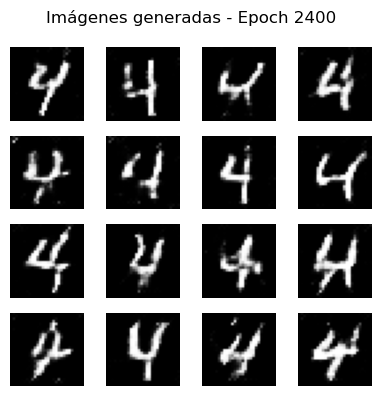

Epoch 2401
  D_real: 0.6780, D_fake: 0.6780, G: 1.0599
Epoch 2402
  D_real: 0.6779, D_fake: 0.6778, G: 1.0601
Epoch 2403
  D_real: 0.6778, D_fake: 0.6778, G: 1.0600
Epoch 2404
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2405
  D_real: 0.6777, D_fake: 0.6777, G: 1.0600
Epoch 2406
  D_real: 0.6777, D_fake: 0.6778, G: 1.0598
Epoch 2407
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2408
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2409
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2410
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2411
  D_real: 0.6777, D_fake: 0.6776, G: 1.0601
Epoch 2412
  D_real: 0.6776, D_fake: 0.6775, G: 1.0601
Epoch 2413
  D_real: 0.6775, D_fake: 0.6774, G: 1.0602
Epoch 2414
  D_real: 0.6774, D_fake: 0.6775, G: 1.0601
Epoch 2415
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2416
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2417
  D_real: 0.6775, D_fake: 0.6774, G: 1.0601
Epoch 2418
  D_real: 0.6773, D_fake: 0.6773, G: 1.0602
Epoch 2419

2025-04-24 19:30:18.976083: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


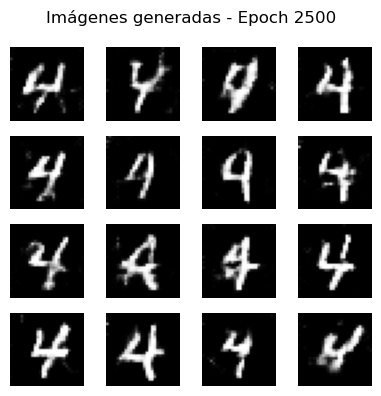

Epoch 2501
  D_real: 0.6741, D_fake: 0.6741, G: 1.0622
Epoch 2502
  D_real: 0.6741, D_fake: 0.6740, G: 1.0623
Epoch 2503
  D_real: 0.6740, D_fake: 0.6740, G: 1.0623
Epoch 2504
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2505
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2506
  D_real: 0.6739, D_fake: 0.6738, G: 1.0624
Epoch 2507
  D_real: 0.6738, D_fake: 0.6737, G: 1.0625
Epoch 2508
  D_real: 0.6738, D_fake: 0.6737, G: 1.0626
Epoch 2509
  D_real: 0.6737, D_fake: 0.6736, G: 1.0627
Epoch 2510
  D_real: 0.6736, D_fake: 0.6735, G: 1.0627
Epoch 2511
  D_real: 0.6735, D_fake: 0.6736, G: 1.0625
Epoch 2512
  D_real: 0.6736, D_fake: 0.6736, G: 1.0625
Epoch 2513
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2514
  D_real: 0.6736, D_fake: 0.6736, G: 1.0623
Epoch 2515
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2516
  D_real: 0.6737, D_fake: 0.6737, G: 1.0623
Epoch 2517
  D_real: 0.6738, D_fake: 0.6738, G: 1.0622
Epoch 2518
  D_real: 0.6738, D_fake: 0.6737, G: 1.0622
Epoch 2519

2025-04-24 19:30:31.634901: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


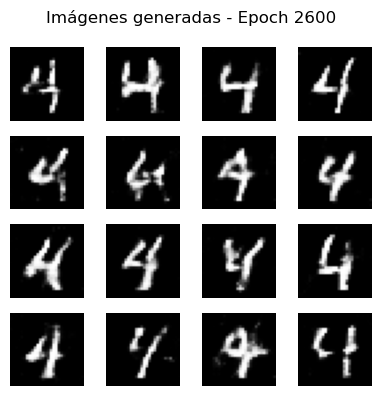

Epoch 2601
  D_real: 0.6720, D_fake: 0.6719, G: 1.0627
Epoch 2602
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2603
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2604
  D_real: 0.6719, D_fake: 0.6718, G: 1.0626
Epoch 2605
  D_real: 0.6718, D_fake: 0.6718, G: 1.0627
Epoch 2606
  D_real: 0.6717, D_fake: 0.6718, G: 1.0626
Epoch 2607
  D_real: 0.6717, D_fake: 0.6717, G: 1.0626
Epoch 2608
  D_real: 0.6717, D_fake: 0.6718, G: 1.0625
Epoch 2609
  D_real: 0.6718, D_fake: 0.6719, G: 1.0624
Epoch 2610
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2611
  D_real: 0.6721, D_fake: 0.6720, G: 1.0624
Epoch 2612
  D_real: 0.6721, D_fake: 0.6721, G: 1.0624
Epoch 2613
  D_real: 0.6721, D_fake: 0.6720, G: 1.0625
Epoch 2614
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2615
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2616
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2617
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2618
  D_real: 0.6720, D_fake: 0.6719, G: 1.0623
Epoch 2619

2025-04-24 19:30:44.467524: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


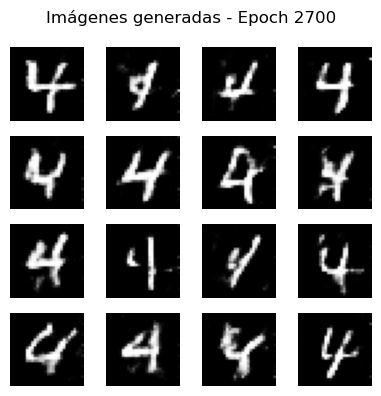

Epoch 2701
  D_real: 0.6697, D_fake: 0.6696, G: 1.0639
Epoch 2702
  D_real: 0.6696, D_fake: 0.6696, G: 1.0638
Epoch 2703
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2704
  D_real: 0.6697, D_fake: 0.6696, G: 1.0638
Epoch 2705
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2706
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2707
  D_real: 0.6696, D_fake: 0.6695, G: 1.0640
Epoch 2708
  D_real: 0.6695, D_fake: 0.6694, G: 1.0641
Epoch 2709
  D_real: 0.6694, D_fake: 0.6693, G: 1.0643
Epoch 2710
  D_real: 0.6693, D_fake: 0.6693, G: 1.0642
Epoch 2711
  D_real: 0.6693, D_fake: 0.6692, G: 1.0643
Epoch 2712
  D_real: 0.6692, D_fake: 0.6692, G: 1.0643
Epoch 2713
  D_real: 0.6692, D_fake: 0.6692, G: 1.0642
Epoch 2714
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2715
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2716
  D_real: 0.6692, D_fake: 0.6692, G: 1.0640
Epoch 2717
  D_real: 0.6693, D_fake: 0.6693, G: 1.0639
Epoch 2718
  D_real: 0.6693, D_fake: 0.6694, G: 1.0639
Epoch 2719

2025-04-24 19:30:57.321672: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


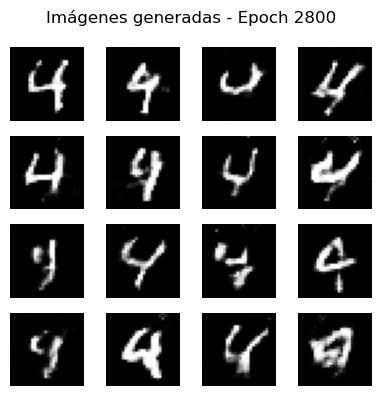

Epoch 2801
  D_real: 0.6674, D_fake: 0.6673, G: 1.0655
Epoch 2802
  D_real: 0.6673, D_fake: 0.6672, G: 1.0657
Epoch 2803
  D_real: 0.6672, D_fake: 0.6671, G: 1.0658
Epoch 2804
  D_real: 0.6671, D_fake: 0.6671, G: 1.0657
Epoch 2805
  D_real: 0.6672, D_fake: 0.6673, G: 1.0657
Epoch 2806
  D_real: 0.6672, D_fake: 0.6673, G: 1.0655
Epoch 2807
  D_real: 0.6674, D_fake: 0.6674, G: 1.0654
Epoch 2808
  D_real: 0.6675, D_fake: 0.6675, G: 1.0654
Epoch 2809
  D_real: 0.6675, D_fake: 0.6674, G: 1.0655
Epoch 2810
  D_real: 0.6675, D_fake: 0.6674, G: 1.0657
Epoch 2811
  D_real: 0.6675, D_fake: 0.6674, G: 1.0659
Epoch 2812
  D_real: 0.6674, D_fake: 0.6673, G: 1.0661
Epoch 2813
  D_real: 0.6673, D_fake: 0.6672, G: 1.0662
Epoch 2814
  D_real: 0.6672, D_fake: 0.6671, G: 1.0663
Epoch 2815
  D_real: 0.6671, D_fake: 0.6670, G: 1.0664
Epoch 2816
  D_real: 0.6669, D_fake: 0.6669, G: 1.0664
Epoch 2817
  D_real: 0.6669, D_fake: 0.6669, G: 1.0663
Epoch 2818
  D_real: 0.6669, D_fake: 0.6669, G: 1.0662
Epoch 2819

2025-04-24 19:31:10.085586: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


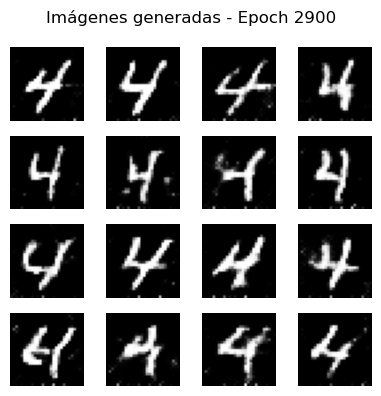

Epoch 2901
  D_real: 0.6636, D_fake: 0.6636, G: 1.0690
Epoch 2902
  D_real: 0.6636, D_fake: 0.6635, G: 1.0691
Epoch 2903
  D_real: 0.6635, D_fake: 0.6635, G: 1.0691
Epoch 2904
  D_real: 0.6635, D_fake: 0.6634, G: 1.0691
Epoch 2905
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2906
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2907
  D_real: 0.6633, D_fake: 0.6633, G: 1.0692
Epoch 2908
  D_real: 0.6632, D_fake: 0.6632, G: 1.0691
Epoch 2909
  D_real: 0.6633, D_fake: 0.6633, G: 1.0691
Epoch 2910
  D_real: 0.6633, D_fake: 0.6632, G: 1.0692
Epoch 2911
  D_real: 0.6632, D_fake: 0.6632, G: 1.0692
Epoch 2912
  D_real: 0.6631, D_fake: 0.6632, G: 1.0692
Epoch 2913
  D_real: 0.6632, D_fake: 0.6631, G: 1.0693
Epoch 2914
  D_real: 0.6632, D_fake: 0.6631, G: 1.0694
Epoch 2915
  D_real: 0.6631, D_fake: 0.6631, G: 1.0694
Epoch 2916
  D_real: 0.6631, D_fake: 0.6631, G: 1.0693
Epoch 2917
  D_real: 0.6631, D_fake: 0.6630, G: 1.0694
Epoch 2918
  D_real: 0.6630, D_fake: 0.6630, G: 1.0693
Epoch 2919

2025-04-24 19:31:22.701263: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


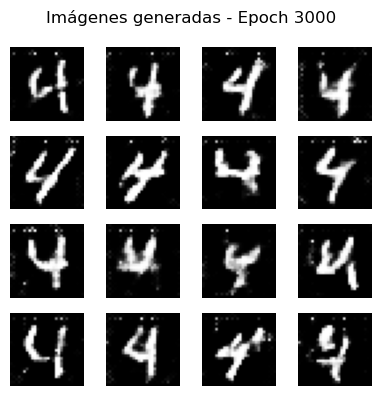

Epoch 3001
  D_real: 0.6605, D_fake: 0.6605, G: 1.0706
Epoch 3002
  D_real: 0.6605, D_fake: 0.6605, G: 1.0705
Epoch 3003
  D_real: 0.6606, D_fake: 0.6606, G: 1.0704
Epoch 3004
  D_real: 0.6607, D_fake: 0.6606, G: 1.0704
Epoch 3005
  D_real: 0.6607, D_fake: 0.6607, G: 1.0704
Epoch 3006
  D_real: 0.6608, D_fake: 0.6608, G: 1.0704
Epoch 3007
  D_real: 0.6608, D_fake: 0.6608, G: 1.0704
Epoch 3008
  D_real: 0.6608, D_fake: 0.6607, G: 1.0705
Epoch 3009
  D_real: 0.6607, D_fake: 0.6606, G: 1.0707
Epoch 3010
  D_real: 0.6606, D_fake: 0.6605, G: 1.0709
Epoch 3011
  D_real: 0.6605, D_fake: 0.6604, G: 1.0712
Epoch 3012
  D_real: 0.6604, D_fake: 0.6603, G: 1.0714
Epoch 3013
  D_real: 0.6602, D_fake: 0.6602, G: 1.0714
Epoch 3014
  D_real: 0.6601, D_fake: 0.6601, G: 1.0714
Epoch 3015
  D_real: 0.6600, D_fake: 0.6601, G: 1.0714
Epoch 3016
  D_real: 0.6600, D_fake: 0.6600, G: 1.0714
Epoch 3017
  D_real: 0.6600, D_fake: 0.6600, G: 1.0716
Epoch 3018
  D_real: 0.6600, D_fake: 0.6599, G: 1.0719
Epoch 3019

2025-04-24 19:31:35.481650: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


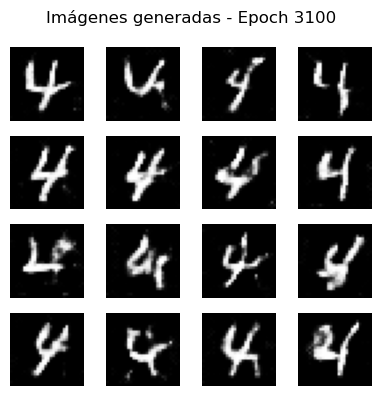

Epoch 3101
  D_real: 0.6572, D_fake: 0.6572, G: 1.0743
Epoch 3102
  D_real: 0.6572, D_fake: 0.6571, G: 1.0743
Epoch 3103
  D_real: 0.6571, D_fake: 0.6570, G: 1.0745
Epoch 3104
  D_real: 0.6570, D_fake: 0.6569, G: 1.0745
Epoch 3105
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3106
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3107
  D_real: 0.6570, D_fake: 0.6570, G: 1.0744
Epoch 3108
  D_real: 0.6570, D_fake: 0.6570, G: 1.0744
Epoch 3109
  D_real: 0.6570, D_fake: 0.6569, G: 1.0744
Epoch 3110
  D_real: 0.6569, D_fake: 0.6569, G: 1.0743
Epoch 3111
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3112
  D_real: 0.6569, D_fake: 0.6569, G: 1.0744
Epoch 3113
  D_real: 0.6569, D_fake: 0.6570, G: 1.0743
Epoch 3114
  D_real: 0.6570, D_fake: 0.6569, G: 1.0744
Epoch 3115
  D_real: 0.6569, D_fake: 0.6568, G: 1.0745
Epoch 3116
  D_real: 0.6568, D_fake: 0.6568, G: 1.0746
Epoch 3117
  D_real: 0.6567, D_fake: 0.6567, G: 1.0747
Epoch 3118
  D_real: 0.6567, D_fake: 0.6566, G: 1.0747
Epoch 3119

2025-04-24 19:31:48.597758: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


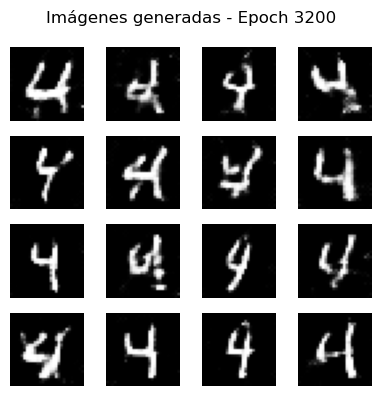

Epoch 3201
  D_real: 0.6548, D_fake: 0.6547, G: 1.0761
Epoch 3202
  D_real: 0.6547, D_fake: 0.6546, G: 1.0762
Epoch 3203
  D_real: 0.6546, D_fake: 0.6546, G: 1.0763
Epoch 3204
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3205
  D_real: 0.6546, D_fake: 0.6546, G: 1.0761
Epoch 3206
  D_real: 0.6546, D_fake: 0.6547, G: 1.0760
Epoch 3207
  D_real: 0.6547, D_fake: 0.6547, G: 1.0760
Epoch 3208
  D_real: 0.6547, D_fake: 0.6547, G: 1.0760
Epoch 3209
  D_real: 0.6548, D_fake: 0.6547, G: 1.0761
Epoch 3210
  D_real: 0.6547, D_fake: 0.6547, G: 1.0761
Epoch 3211
  D_real: 0.6547, D_fake: 0.6547, G: 1.0762
Epoch 3212
  D_real: 0.6546, D_fake: 0.6546, G: 1.0763
Epoch 3213
  D_real: 0.6546, D_fake: 0.6545, G: 1.0763
Epoch 3214
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3215
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3216
  D_real: 0.6545, D_fake: 0.6545, G: 1.0762
Epoch 3217
  D_real: 0.6545, D_fake: 0.6545, G: 1.0763
Epoch 3218
  D_real: 0.6545, D_fake: 0.6546, G: 1.0762
Epoch 3219

2025-04-24 19:32:01.634049: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


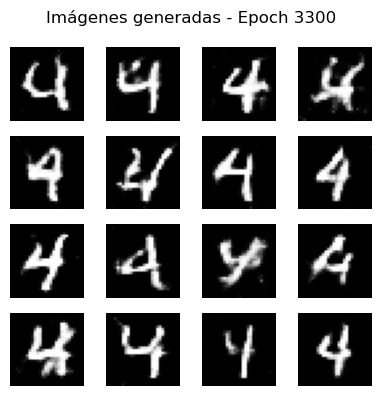

Epoch 3301
  D_real: 0.6523, D_fake: 0.6524, G: 1.0779
Epoch 3302
  D_real: 0.6524, D_fake: 0.6524, G: 1.0778
Epoch 3303
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3304
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3305
  D_real: 0.6525, D_fake: 0.6525, G: 1.0779
Epoch 3306
  D_real: 0.6525, D_fake: 0.6524, G: 1.0781
Epoch 3307
  D_real: 0.6525, D_fake: 0.6524, G: 1.0781
Epoch 3308
  D_real: 0.6524, D_fake: 0.6524, G: 1.0782
Epoch 3309
  D_real: 0.6523, D_fake: 0.6523, G: 1.0781
Epoch 3310
  D_real: 0.6524, D_fake: 0.6524, G: 1.0780
Epoch 3311
  D_real: 0.6524, D_fake: 0.6524, G: 1.0779
Epoch 3312
  D_real: 0.6524, D_fake: 0.6524, G: 1.0779
Epoch 3313
  D_real: 0.6524, D_fake: 0.6525, G: 1.0778
Epoch 3314
  D_real: 0.6525, D_fake: 0.6525, G: 1.0777
Epoch 3315
  D_real: 0.6525, D_fake: 0.6525, G: 1.0778
Epoch 3316
  D_real: 0.6526, D_fake: 0.6526, G: 1.0778
Epoch 3317
  D_real: 0.6526, D_fake: 0.6526, G: 1.0779
Epoch 3318
  D_real: 0.6526, D_fake: 0.6525, G: 1.0779
Epoch 3319

2025-04-24 19:32:14.253918: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


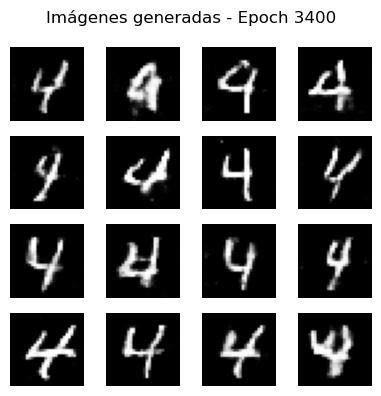

Epoch 3401
  D_real: 0.6509, D_fake: 0.6509, G: 1.0788
Epoch 3402
  D_real: 0.6508, D_fake: 0.6508, G: 1.0788
Epoch 3403
  D_real: 0.6508, D_fake: 0.6508, G: 1.0789
Epoch 3404
  D_real: 0.6508, D_fake: 0.6509, G: 1.0788
Epoch 3405
  D_real: 0.6509, D_fake: 0.6508, G: 1.0788
Epoch 3406
  D_real: 0.6508, D_fake: 0.6508, G: 1.0788
Epoch 3407
  D_real: 0.6508, D_fake: 0.6507, G: 1.0788
Epoch 3408
  D_real: 0.6507, D_fake: 0.6506, G: 1.0789
Epoch 3409
  D_real: 0.6506, D_fake: 0.6506, G: 1.0790
Epoch 3410
  D_real: 0.6506, D_fake: 0.6505, G: 1.0791
Epoch 3411
  D_real: 0.6505, D_fake: 0.6505, G: 1.0791
Epoch 3412
  D_real: 0.6504, D_fake: 0.6504, G: 1.0790
Epoch 3413
  D_real: 0.6504, D_fake: 0.6504, G: 1.0790
Epoch 3414
  D_real: 0.6505, D_fake: 0.6504, G: 1.0790
Epoch 3415
  D_real: 0.6505, D_fake: 0.6504, G: 1.0791
Epoch 3416
  D_real: 0.6504, D_fake: 0.6503, G: 1.0792
Epoch 3417
  D_real: 0.6503, D_fake: 0.6502, G: 1.0793
Epoch 3418
  D_real: 0.6502, D_fake: 0.6501, G: 1.0794
Epoch 3419

2025-04-24 19:32:26.875305: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


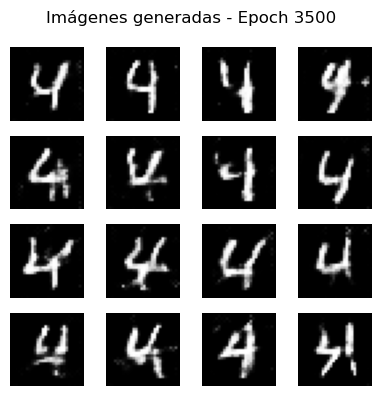

Epoch 3501
  D_real: 0.6481, D_fake: 0.6481, G: 1.0827
Epoch 3502
  D_real: 0.6481, D_fake: 0.6480, G: 1.0829
Epoch 3503
  D_real: 0.6480, D_fake: 0.6479, G: 1.0830
Epoch 3504
  D_real: 0.6479, D_fake: 0.6478, G: 1.0831
Epoch 3505
  D_real: 0.6478, D_fake: 0.6477, G: 1.0832
Epoch 3506
  D_real: 0.6477, D_fake: 0.6477, G: 1.0832
Epoch 3507
  D_real: 0.6477, D_fake: 0.6477, G: 1.0832
Epoch 3508
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3509
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3510
  D_real: 0.6476, D_fake: 0.6476, G: 1.0832
Epoch 3511
  D_real: 0.6476, D_fake: 0.6476, G: 1.0831
Epoch 3512
  D_real: 0.6477, D_fake: 0.6477, G: 1.0831
Epoch 3513
  D_real: 0.6477, D_fake: 0.6477, G: 1.0830
Epoch 3514
  D_real: 0.6478, D_fake: 0.6478, G: 1.0830
Epoch 3515
  D_real: 0.6479, D_fake: 0.6478, G: 1.0830
Epoch 3516
  D_real: 0.6478, D_fake: 0.6479, G: 1.0830
Epoch 3517
  D_real: 0.6479, D_fake: 0.6478, G: 1.0833
Epoch 3518
  D_real: 0.6478, D_fake: 0.6477, G: 1.0835
Epoch 3519

2025-04-24 19:32:39.949025: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


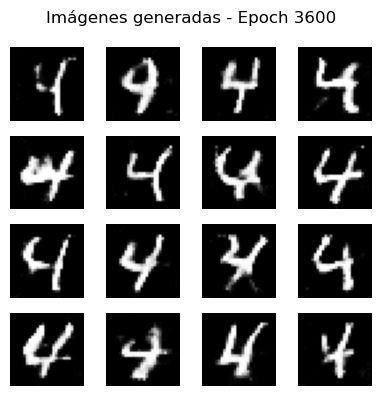

Epoch 3601
  D_real: 0.6451, D_fake: 0.6451, G: 1.0868
Epoch 3602
  D_real: 0.6451, D_fake: 0.6452, G: 1.0867
Epoch 3603
  D_real: 0.6452, D_fake: 0.6452, G: 1.0866
Epoch 3604
  D_real: 0.6452, D_fake: 0.6452, G: 1.0866
Epoch 3605
  D_real: 0.6452, D_fake: 0.6451, G: 1.0867
Epoch 3606
  D_real: 0.6452, D_fake: 0.6452, G: 1.0868
Epoch 3607
  D_real: 0.6451, D_fake: 0.6451, G: 1.0869
Epoch 3608
  D_real: 0.6451, D_fake: 0.6450, G: 1.0870
Epoch 3609
  D_real: 0.6450, D_fake: 0.6450, G: 1.0870
Epoch 3610
  D_real: 0.6450, D_fake: 0.6450, G: 1.0870
Epoch 3611
  D_real: 0.6450, D_fake: 0.6449, G: 1.0870
Epoch 3612
  D_real: 0.6449, D_fake: 0.6448, G: 1.0871
Epoch 3613
  D_real: 0.6448, D_fake: 0.6448, G: 1.0871
Epoch 3614
  D_real: 0.6448, D_fake: 0.6447, G: 1.0871
Epoch 3615
  D_real: 0.6447, D_fake: 0.6448, G: 1.0870
Epoch 3616
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3617
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3618
  D_real: 0.6447, D_fake: 0.6447, G: 1.0870
Epoch 3619

2025-04-24 19:32:52.762966: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


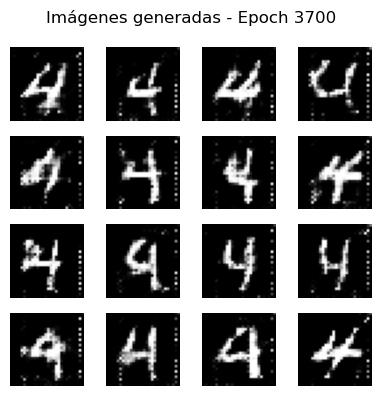

Epoch 3701
  D_real: 0.6408, D_fake: 0.6408, G: 1.0962
Epoch 3702
  D_real: 0.6407, D_fake: 0.6407, G: 1.0967
Epoch 3703
  D_real: 0.6406, D_fake: 0.6405, G: 1.0975
Epoch 3704
  D_real: 0.6405, D_fake: 0.6404, G: 1.0987
Epoch 3705
  D_real: 0.6404, D_fake: 0.6403, G: 1.1000
Epoch 3706
  D_real: 0.6403, D_fake: 0.6402, G: 1.1013
Epoch 3707
  D_real: 0.6401, D_fake: 0.6400, G: 1.1026
Epoch 3708
  D_real: 0.6400, D_fake: 0.6399, G: 1.1038
Epoch 3709
  D_real: 0.6399, D_fake: 0.6398, G: 1.1049
Epoch 3710
  D_real: 0.6398, D_fake: 0.6397, G: 1.1059
Epoch 3711
  D_real: 0.6396, D_fake: 0.6396, G: 1.1066
Epoch 3712
  D_real: 0.6395, D_fake: 0.6394, G: 1.1073
Epoch 3713
  D_real: 0.6394, D_fake: 0.6393, G: 1.1079
Epoch 3714
  D_real: 0.6393, D_fake: 0.6392, G: 1.1086
Epoch 3715
  D_real: 0.6391, D_fake: 0.6391, G: 1.1091
Epoch 3716
  D_real: 0.6390, D_fake: 0.6389, G: 1.1097
Epoch 3717
  D_real: 0.6389, D_fake: 0.6388, G: 1.1100
Epoch 3718
  D_real: 0.6388, D_fake: 0.6387, G: 1.1105
Epoch 3719

2025-04-24 19:33:05.490058: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


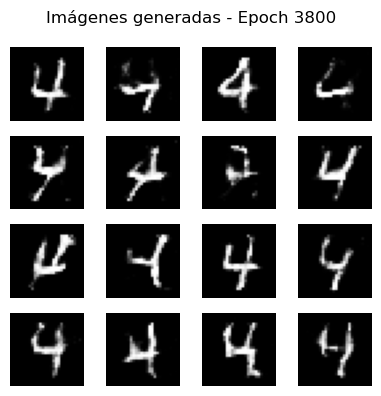

Epoch 3801
  D_real: 0.6353, D_fake: 0.6353, G: 1.1161
Epoch 3802
  D_real: 0.6353, D_fake: 0.6352, G: 1.1164
Epoch 3803
  D_real: 0.6351, D_fake: 0.6351, G: 1.1166
Epoch 3804
  D_real: 0.6351, D_fake: 0.6350, G: 1.1165
Epoch 3805
  D_real: 0.6350, D_fake: 0.6350, G: 1.1165
Epoch 3806
  D_real: 0.6350, D_fake: 0.6349, G: 1.1164
Epoch 3807
  D_real: 0.6349, D_fake: 0.6349, G: 1.1164
Epoch 3808
  D_real: 0.6349, D_fake: 0.6348, G: 1.1166
Epoch 3809
  D_real: 0.6348, D_fake: 0.6347, G: 1.1168
Epoch 3810
  D_real: 0.6347, D_fake: 0.6347, G: 1.1168
Epoch 3811
  D_real: 0.6347, D_fake: 0.6347, G: 1.1168
Epoch 3812
  D_real: 0.6347, D_fake: 0.6347, G: 1.1167
Epoch 3813
  D_real: 0.6347, D_fake: 0.6346, G: 1.1168
Epoch 3814
  D_real: 0.6346, D_fake: 0.6347, G: 1.1167
Epoch 3815
  D_real: 0.6348, D_fake: 0.6348, G: 1.1167
Epoch 3816
  D_real: 0.6348, D_fake: 0.6347, G: 1.1167
Epoch 3817
  D_real: 0.6348, D_fake: 0.6348, G: 1.1166
Epoch 3818
  D_real: 0.6348, D_fake: 0.6348, G: 1.1166
Epoch 3819

2025-04-24 19:33:18.079375: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


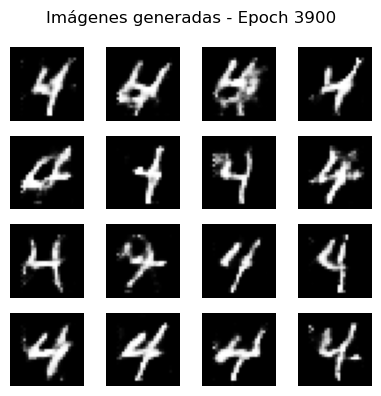

Epoch 3901
  D_real: 0.6334, D_fake: 0.6333, G: 1.1179
Epoch 3902
  D_real: 0.6333, D_fake: 0.6333, G: 1.1180
Epoch 3903
  D_real: 0.6332, D_fake: 0.6333, G: 1.1178
Epoch 3904
  D_real: 0.6333, D_fake: 0.6334, G: 1.1178
Epoch 3905
  D_real: 0.6334, D_fake: 0.6334, G: 1.1177
Epoch 3906
  D_real: 0.6334, D_fake: 0.6333, G: 1.1178
Epoch 3907
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3908
  D_real: 0.6334, D_fake: 0.6333, G: 1.1178
Epoch 3909
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3910
  D_real: 0.6334, D_fake: 0.6334, G: 1.1178
Epoch 3911
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3912
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3913
  D_real: 0.6335, D_fake: 0.6335, G: 1.1177
Epoch 3914
  D_real: 0.6336, D_fake: 0.6336, G: 1.1177
Epoch 3915
  D_real: 0.6336, D_fake: 0.6335, G: 1.1179
Epoch 3916
  D_real: 0.6335, D_fake: 0.6335, G: 1.1180
Epoch 3917
  D_real: 0.6335, D_fake: 0.6335, G: 1.1181
Epoch 3918
  D_real: 0.6335, D_fake: 0.6335, G: 1.1180
Epoch 3919

2025-04-24 19:33:31.239400: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


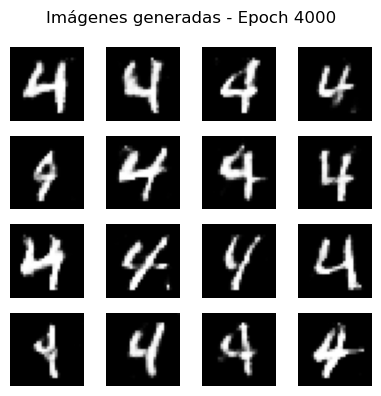

Modelo generador guardado en mejor_generador.h5


In [16]:
# Entrenamos hasta la mejor epoc
entrenar_gan_guardar(4000,"mejor_generador.h5")

In [17]:
def generar_y_visualizar_imagenes(ruta_generador, cantidad_imagenes=10, columnas=4):
    import math

    generador = keras.models.load_model(ruta_generador)

    # Creamos ruido para generar imágenes falsas
    ruido = np.random.normal(0, 1, (cantidad_imagenes, TAM_ENTRADA))

    # Generamos las imágenes
    imagenes_generadas = generador.predict(ruido)

    # Normalizamos imágenes de [-1, 1] a [0, 1] si es necesario
    imagenes_generadas = (imagenes_generadas + 1) / 2

    filas = math.ceil(cantidad_imagenes / columnas)
    fig, axs = plt.subplots(filas, columnas, figsize=(columnas * 2.5, filas * 2.5))
    axs = axs.ravel()

    for i in range(cantidad_imagenes):
        axs[i].imshow(imagenes_generadas[i, :, :, 0], cmap='gray')
        axs[i].axis('off')

    for i in range(cantidad_imagenes, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


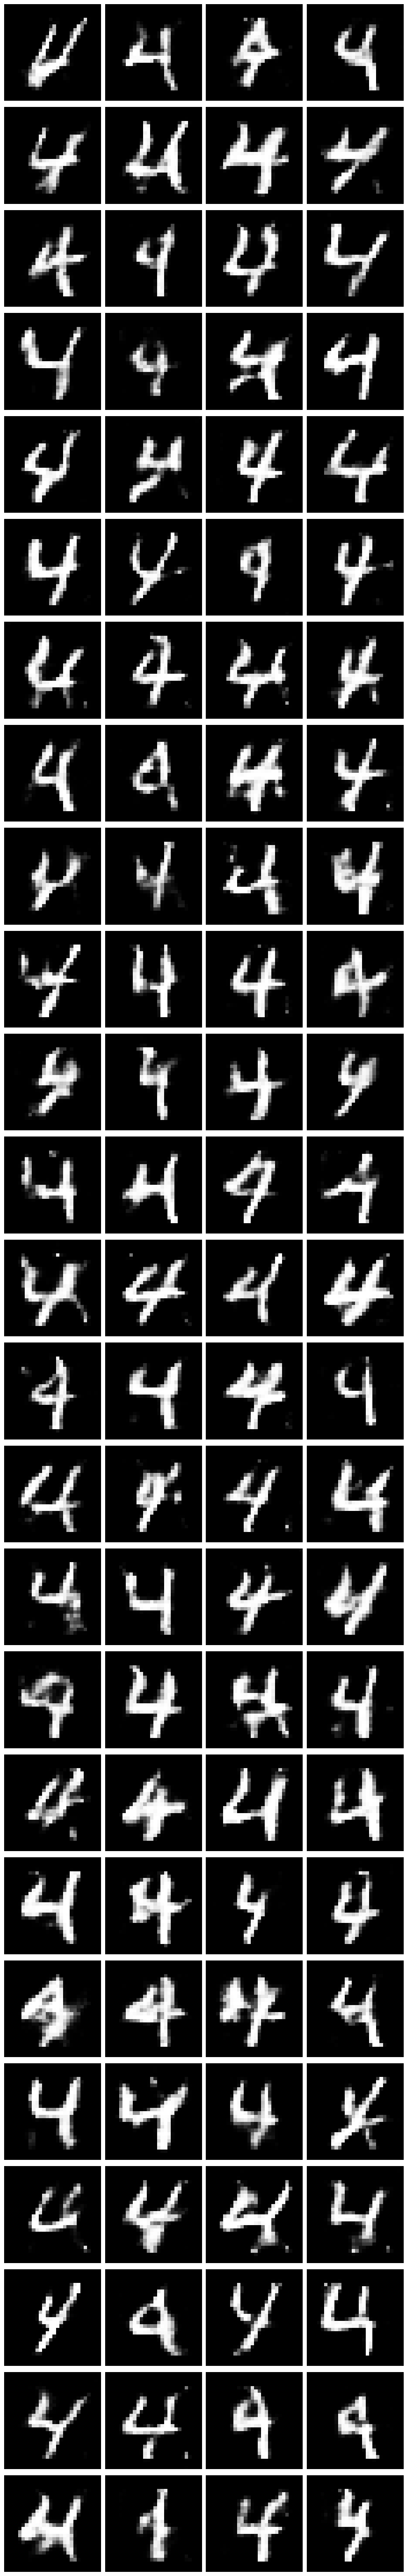

In [18]:
generar_y_visualizar_imagenes(r"mejor_generador.h5", 100)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from PIL import Image

def generar_y_guardar_imagenes(ruta_generador, carpeta_salida, cantidad_imagenes=4000, tam_entrada=100, prefijo_nombre="digito4"):
    # Crear carpeta de salida si no existe
    os.makedirs(carpeta_salida, exist_ok=True)

    # Cargar el modelo generador
    generador = keras.models.load_model(ruta_generador)

    # Generar ruido aleatorio
    ruido = np.random.normal(0, 1, (cantidad_imagenes, tam_entrada))

    # Generar imágenes
    imagenes_generadas = generador.predict(ruido)

    # Normalizar imágenes de [-1, 1] a [0, 1] si es necesario
    imagenes_generadas = (imagenes_generadas + 1) / 2.0

    for i in range(cantidad_imagenes):
        imagen = imagenes_generadas[i]

        # Eliminar canal si es solo 1 (grayscale)
        if imagen.shape[-1] == 1:
            imagen = imagen[:, :, 0]

        # Convertir a imagen tipo PIL
        imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

        # Guardar imagen
        nombre_archivo = f"{prefijo_nombre}_{i}.png"
        ruta_archivo = os.path.join(carpeta_salida, nombre_archivo)
        imagen_pil.save(ruta_archivo)

    print(f"Se guardaron {cantidad_imagenes} imágenes en la carpeta: {carpeta_salida}")


In [20]:
# Función para evaluar la calidad visual usando SSIM
def evaluar_calidad_visual(imagenes_generadas, imagenes_reales):
    calidad_total = 0
    for img_gen, img_real in zip(imagenes_generadas, imagenes_reales):
        img_gen = (img_gen + 1) / 2  # Desnormalizar a rango [0, 1]
        img_real = (img_real + 1) / 2  # Desnormalizar a rango [0, 1]
        calidad_total += ssim(img_gen.squeeze(), img_real.squeeze(), data_range=1.0)
    return calidad_total / len(imagenes_generadas)

In [21]:
generar_y_guardar_imagenes(
    ruta_generador="mejor_generador.h5",
    carpeta_salida="imagenes_generadas",
    cantidad_imagenes=4000,
    tam_entrada=100,  # Cambia esto si tu generador espera otra dimensión
    prefijo_nombre="digito4"
)
# Cargar imágenes reales del dígito "4"
imagenes_reales = cargar_datos()[:100]  # Selecciona 100 imágenes reales para comparar

# Cargar imágenes generadas
imagenes_generadas = []
for i in range(100):
    img = plt.imread(f"imagenes_generadas/digito4_{i}.png")
    imagenes_generadas.append(img)
imagenes_generadas = np.array(imagenes_generadas)

# Evaluar calidad visual
calidad = evaluar_calidad_visual(imagenes_generadas, imagenes_reales)
print(f"Calidad visual (SSIM): {calidad}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Se guardaron 4000 imágenes en la carpeta: imagenes_generadas
Cargando dígitos "4" desde MNIST...¡Listo!
Calidad visual (SSIM): 0.08437374720567992
